# Implementation of GAN with R1 Regularizer
Reference: https://arxiv.org/pdf/1801.04406

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys
import glob
from tqdm import tqdm

In [4]:
from PIL import Image

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'R1'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
IMAGE_DIM = (64, 64, 3)

In [8]:
def tensor2img(tensor):
    img = (np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.
    return img

In [9]:
def get_sample_image(G, n_noise=100, n_samples=64):
    """
        save sample 100 images
    """
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(DEVICE) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return result

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, downsample=None, groups=1):
        super(ResidualBlock, self).__init__()
        p = kernel_size//2
        self.conv1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size, stride=stride, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size, padding=p),
            nn.LeakyReLU(0.2)
        )
        self.proj = nn.Conv2d(inplanes, planes, 1) if inplanes != planes else None
    
    def forward(self, x):
        identity = x
        
        y = self.conv1(x)
        y = self.conv2(y)
        
        identity = identity if self.proj is None else self.proj(identity)
        y = y + identity
        return y

In [11]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator
    """
    def __init__(self, in_channel=1):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1), # (N, 64, 64, 64)
            ResidualBlock(64, 128),
            nn.AvgPool2d(3, 2, padding=1), # (N, 128, 32, 32)
            ResidualBlock(128, 256),
            nn.AvgPool2d(3, 2, padding=1), # (N, 256, 16, 16)
            ResidualBlock(256, 512),
            nn.AvgPool2d(3, 2, padding=1), # (N, 512, 8, 8)
            ResidualBlock(512, 1024),
            nn.AvgPool2d(3, 2, padding=1) # (N, 1024, 4, 4)
        )
        self.fc = nn.Linear(1024*4*4, 1) # (N, 1)
        
    def forward(self, x):
        B = x.size(0)
        h = self.D(x)
        h = h.view(B, -1)
        y = self.fc(h)
        return y

In [12]:
class Generator(nn.Module):
    """
        Convolutional Generator
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=512):
        super(Generator, self).__init__()
        self.fc = nn.Linear(n_noise, 1024*4*4)
        self.G = nn.Sequential(
            ResidualBlock(1024, 512),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 512, 8, 8)
            ResidualBlock(512, 256),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 256, 16, 16)
            ResidualBlock(256, 128),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 128, 32, 32)
            ResidualBlock(128, 64),
            nn.Upsample(scale_factor=2, mode='bilinear'), # (N, 64, 64, 64)
            ResidualBlock(64, 64),
            nn.Conv2d(64, out_channel, 3, padding=1) # (N, 3, 64, 64)
        )
        
    def forward(self, z):
        B = z.size(0)
        h = self.fc(z)
        h = h.view(B, 1024, 4, 4)
        x = self.G(h)
        return x

In [13]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

In [14]:
dataset = datasets.ImageFolder(root='/home/abhijit/IndianCars', transform=transform)

In [15]:
batch_size = 64
n_noise = 256

In [16]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [17]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1], n_noise=n_noise).to(DEVICE)

In [18]:
D_opt = torch.optim.RMSprop(D.parameters(), lr=1e-4, alpha=0.99)
G_opt = torch.optim.RMSprop(G.parameters(), lr=1e-4, alpha=0.99)

In [19]:
# D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3, 10, 17], gamma=0.6)
# G_scheduler = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3, 10, 17], gamma=0.6)

In [20]:
# criterion = nn.L1Loss()
def r1loss(inputs, label=None):
    # non-saturating loss with R1 regularization
    l = -1 if label else 1
    return F.softplus(l*inputs).mean()

In [21]:
max_epoch = 2000
step = 0

In [22]:
log_term = 20
save_term = 200

In [23]:
r1_gamma = 1

In [24]:
steps_per_epoch = len(data_loader.dataset) // batch_size
steps_per_epoch

7

In [25]:
if not os.path.exists('samples'):
    os.makedirs('samples')
    
if not os.path.exists('ckpt'):
    os.makedirs('ckpt')
    
g_loss = []
d_loss = []
g_p = []

In [26]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [28]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(tqdm(data_loader, total=len(data_loader))):
        G.zero_grad()
        # Training Discriminator
        x = images.to(DEVICE)
        x.requires_grad = True
        x_outputs = D(x)
        d_real_loss = r1loss(x_outputs, True)
        # Reference >> https://github.com/rosinality/style-based-gan-pytorch/blob/a3d000e707b70d1a5fc277912dc9d7432d6e6069/train.py
        # little different with original DiracGANstep
        grad_real = grad(outputs=x_outputs.sum(), inputs=x, create_graph=True)[0]
        grad_penalty = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty = 0.5*r1_gamma*grad_penalty
        g_p.append(grad_penalty.item())
        D_x_loss = d_real_loss + grad_penalty

        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        
        z_outputs = D(x_fake.detach())
        D_z_loss = r1loss(z_outputs, False)
        D_loss = D_x_loss + D_z_loss
        d_loss.append(D_loss.item())
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake)
        G_loss = r1loss(z_outputs, True)
        g_loss.append(G_loss.item())
        
        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        if step % save_term == 0:
            save_checkpoint({'global_step': step,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict(),
                 'g_loss': g_loss,
                 'd_loss': d_loss,
                 'g_p': g_p},
                'ckpt/r1gan{:06d}.pth.tar'.format(step),)
        
        if step % log_term == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, gp: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), grad_penalty.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise, n_samples=25)
            #img = np.array((img - np.min(img)) / (np.max(img) - np.min(img)))
            #img = img + (img * 255)
            img = np.clip(img,0,1)            
            img /= np.max(img)
            
            imsave('samples/{}_step{:06d}.jpg'.format(MODEL_NAME, step), img)
            G.train()
        
        step += 1
#     D_scheduler.step()
#     G_scheduler.step()

  0%|          | 0/7 [00:00<?, ?it/s]/home/abhijit/.virtualenvs/dl4cv/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
 14%|█▍        | 1/7 [00:02<00:15,  2.63s/it]

Epoch: 0/2000, Step: 0, D Loss: 1.3898, G Loss: 0.4758, gp: 0.0000, Time:22:39:16


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 2/2000, Step: 20, D Loss: 0.3130, G Loss: 1.7989, gp: 0.0064, Time:22:39:30


 86%|████████▌ | 6/7 [00:04<00:00,  1.41it/s]

Epoch: 5/2000, Step: 40, D Loss: 0.8738, G Loss: 1.2312, gp: 0.0035, Time:22:39:43


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 8/2000, Step: 60, D Loss: 0.7832, G Loss: 1.4227, gp: 0.0054, Time:22:39:57


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 11/2000, Step: 80, D Loss: 0.8708, G Loss: 1.6411, gp: 0.0063, Time:22:40:11


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 14/2000, Step: 100, D Loss: 0.7672, G Loss: 1.8665, gp: 0.0080, Time:22:40:24


 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

Epoch: 17/2000, Step: 120, D Loss: 0.4222, G Loss: 2.6564, gp: 0.0089, Time:22:40:38


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 20/2000, Step: 140, D Loss: 1.0669, G Loss: 2.7822, gp: 0.0066, Time:22:40:52


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 22/2000, Step: 160, D Loss: 1.1421, G Loss: 1.5547, gp: 0.0071, Time:22:41:05


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 25/2000, Step: 180, D Loss: 1.1328, G Loss: 0.3202, gp: 0.0178, Time:22:41:19


 71%|███████▏  | 5/7 [00:05<00:02,  1.19s/it]

Epoch: 28/2000, Step: 200, D Loss: 1.5632, G Loss: 0.6774, gp: 0.0167, Time:22:41:35


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 31/2000, Step: 220, D Loss: 0.5376, G Loss: 1.9002, gp: 0.0155, Time:22:41:48


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 34/2000, Step: 240, D Loss: 0.6131, G Loss: 0.7577, gp: 0.0315, Time:22:42:02


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 37/2000, Step: 260, D Loss: 1.4244, G Loss: 2.9792, gp: 0.0120, Time:22:42:16


 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]

Epoch: 40/2000, Step: 280, D Loss: 0.8556, G Loss: 1.6353, gp: 0.0315, Time:22:42:30


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 42/2000, Step: 300, D Loss: 1.6301, G Loss: 0.3452, gp: 0.0549, Time:22:42:43


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 45/2000, Step: 320, D Loss: 1.2084, G Loss: 0.5394, gp: 0.0253, Time:22:42:57


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 48/2000, Step: 340, D Loss: 0.6033, G Loss: 2.1727, gp: 0.0148, Time:22:43:11


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 51/2000, Step: 360, D Loss: 1.3305, G Loss: 2.1770, gp: 0.0212, Time:22:43:25


 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]

Epoch: 54/2000, Step: 380, D Loss: 1.7150, G Loss: 1.4384, gp: 0.0160, Time:22:43:39


 29%|██▊       | 2/7 [00:03<00:06,  1.26s/it]

Epoch: 57/2000, Step: 400, D Loss: 1.1026, G Loss: 1.5506, gp: 0.0444, Time:22:43:54


 14%|█▍        | 1/7 [00:00<00:05,  1.10it/s]

Epoch: 60/2000, Step: 420, D Loss: 0.9149, G Loss: 1.1262, gp: 0.0136, Time:22:44:08


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 62/2000, Step: 440, D Loss: 0.9039, G Loss: 1.4364, gp: 0.0252, Time:22:44:21


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 65/2000, Step: 460, D Loss: 0.8803, G Loss: 2.4468, gp: 0.0380, Time:22:44:35


 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]

Epoch: 68/2000, Step: 480, D Loss: 1.7427, G Loss: 2.8715, gp: 0.0350, Time:22:44:49


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 71/2000, Step: 500, D Loss: 0.2639, G Loss: 3.3202, gp: 0.0686, Time:22:45:03


 43%|████▎     | 3/7 [00:02<00:03,  1.31it/s]

Epoch: 74/2000, Step: 520, D Loss: 0.7161, G Loss: 1.7262, gp: 0.0596, Time:22:45:17


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 77/2000, Step: 540, D Loss: 0.8900, G Loss: 0.9497, gp: 0.0550, Time:22:45:31


 14%|█▍        | 1/7 [00:00<00:05,  1.09it/s]

Epoch: 80/2000, Step: 560, D Loss: 0.4673, G Loss: 2.0857, gp: 0.0892, Time:22:45:44


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 82/2000, Step: 580, D Loss: 0.7499, G Loss: 1.4507, gp: 0.0543, Time:22:45:58


 86%|████████▌ | 6/7 [00:05<00:01,  1.17s/it]

Epoch: 85/2000, Step: 600, D Loss: 0.6005, G Loss: 2.9761, gp: 0.0373, Time:22:46:14


 71%|███████▏  | 5/7 [00:03<00:01,  1.39it/s]

Epoch: 88/2000, Step: 620, D Loss: 0.8684, G Loss: 1.2121, gp: 0.0242, Time:22:46:27


 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]

Epoch: 91/2000, Step: 640, D Loss: 0.5771, G Loss: 2.5159, gp: 0.0739, Time:22:46:41


 43%|████▎     | 3/7 [00:02<00:03,  1.32it/s]

Epoch: 94/2000, Step: 660, D Loss: 1.1376, G Loss: 3.0542, gp: 0.0633, Time:22:46:55


 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]

Epoch: 97/2000, Step: 680, D Loss: 1.0884, G Loss: 0.8702, gp: 0.1021, Time:22:47:09


 14%|█▍        | 1/7 [00:00<00:05,  1.12it/s]

Epoch: 100/2000, Step: 700, D Loss: 0.6445, G Loss: 2.5455, gp: 0.0478, Time:22:47:23


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 102/2000, Step: 720, D Loss: 0.4798, G Loss: 5.4289, gp: 0.0644, Time:22:47:36


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 105/2000, Step: 740, D Loss: 1.1345, G Loss: 1.7769, gp: 0.0552, Time:22:47:50


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 108/2000, Step: 760, D Loss: 0.4836, G Loss: 2.8199, gp: 0.0799, Time:22:48:04


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 111/2000, Step: 780, D Loss: 0.5139, G Loss: 1.9296, gp: 0.0740, Time:22:48:18


 43%|████▎     | 3/7 [00:03<00:04,  1.23s/it]

Epoch: 114/2000, Step: 800, D Loss: 0.5899, G Loss: 3.0346, gp: 0.0737, Time:22:48:33


 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]

Epoch: 117/2000, Step: 820, D Loss: 0.4195, G Loss: 2.3250, gp: 0.0723, Time:22:48:47


 14%|█▍        | 1/7 [00:00<00:05,  1.02it/s]

Epoch: 120/2000, Step: 840, D Loss: 0.6738, G Loss: 1.5403, gp: 0.0391, Time:22:49:01


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 122/2000, Step: 860, D Loss: 0.4630, G Loss: 2.2035, gp: 0.0615, Time:22:49:14


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 125/2000, Step: 880, D Loss: 0.4916, G Loss: 2.7229, gp: 0.0726, Time:22:49:28


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 128/2000, Step: 900, D Loss: 0.5246, G Loss: 2.7299, gp: 0.0765, Time:22:49:42


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 131/2000, Step: 920, D Loss: 0.7661, G Loss: 2.0345, gp: 0.0537, Time:22:49:56


 43%|████▎     | 3/7 [00:02<00:03,  1.31it/s]

Epoch: 134/2000, Step: 940, D Loss: 1.8237, G Loss: 3.1665, gp: 0.0974, Time:22:50:10


 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]

Epoch: 137/2000, Step: 960, D Loss: 0.8538, G Loss: 1.9106, gp: 0.0621, Time:22:50:24


 14%|█▍        | 1/7 [00:00<00:05,  1.08it/s]

Epoch: 140/2000, Step: 980, D Loss: 0.3662, G Loss: 2.2630, gp: 0.1045, Time:22:50:37


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 142/2000, Step: 1000, D Loss: 0.6949, G Loss: 3.1224, gp: 0.0715, Time:22:50:53


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 145/2000, Step: 1020, D Loss: 1.1745, G Loss: 1.0312, gp: 0.0071, Time:22:51:07


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 148/2000, Step: 1040, D Loss: 0.4550, G Loss: 3.5751, gp: 0.0996, Time:22:51:20


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 151/2000, Step: 1060, D Loss: 0.6444, G Loss: 3.3674, gp: 0.0638, Time:22:51:34


 43%|████▎     | 3/7 [00:02<00:03,  1.31it/s]

Epoch: 154/2000, Step: 1080, D Loss: 0.9724, G Loss: 1.8092, gp: 0.0413, Time:22:51:48


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 157/2000, Step: 1100, D Loss: 0.6805, G Loss: 3.0558, gp: 0.0656, Time:22:52:02


 14%|█▍        | 1/7 [00:00<00:05,  1.09it/s]

Epoch: 160/2000, Step: 1120, D Loss: 0.6170, G Loss: 3.3192, gp: 0.0907, Time:22:52:16


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 162/2000, Step: 1140, D Loss: 0.5625, G Loss: 1.5619, gp: 0.0839, Time:22:52:29


 86%|████████▌ | 6/7 [00:04<00:00,  1.40it/s]

Epoch: 165/2000, Step: 1160, D Loss: 2.0166, G Loss: 0.9202, gp: 0.1169, Time:22:52:43


 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]

Epoch: 168/2000, Step: 1180, D Loss: 0.7617, G Loss: 4.1200, gp: 0.0863, Time:22:52:57


 57%|█████▋    | 4/7 [00:04<00:03,  1.22s/it]

Epoch: 171/2000, Step: 1200, D Loss: 1.7730, G Loss: 4.4463, gp: 0.1047, Time:22:53:12


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 174/2000, Step: 1220, D Loss: 0.3248, G Loss: 4.2054, gp: 0.1091, Time:22:53:26


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 177/2000, Step: 1240, D Loss: 0.5052, G Loss: 3.7865, gp: 0.1084, Time:22:53:40


 14%|█▍        | 1/7 [00:00<00:05,  1.13it/s]

Epoch: 180/2000, Step: 1260, D Loss: 0.4192, G Loss: 2.4451, gp: 0.1034, Time:22:53:54


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 182/2000, Step: 1280, D Loss: 0.4467, G Loss: 1.7212, gp: 0.1246, Time:22:54:07


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 185/2000, Step: 1300, D Loss: 0.3307, G Loss: 3.8642, gp: 0.1083, Time:22:54:21


 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]

Epoch: 188/2000, Step: 1320, D Loss: 0.3653, G Loss: 2.6613, gp: 0.1027, Time:22:54:35


 57%|█████▋    | 4/7 [00:02<00:02,  1.34it/s]

Epoch: 191/2000, Step: 1340, D Loss: 0.4668, G Loss: 2.1547, gp: 0.0988, Time:22:54:49


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 194/2000, Step: 1360, D Loss: 0.7466, G Loss: 2.8488, gp: 0.0840, Time:22:55:03


 29%|██▊       | 2/7 [00:01<00:03,  1.30it/s]

Epoch: 197/2000, Step: 1380, D Loss: 0.3067, G Loss: 3.2793, gp: 0.1220, Time:22:55:17


 14%|█▍        | 1/7 [00:02<00:15,  2.50s/it]

Epoch: 200/2000, Step: 1400, D Loss: 0.9360, G Loss: 1.1703, gp: 0.0317, Time:22:55:32


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 202/2000, Step: 1420, D Loss: 0.5309, G Loss: 2.3706, gp: 0.1269, Time:22:55:46


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 205/2000, Step: 1440, D Loss: 0.3537, G Loss: 2.8899, gp: 0.0928, Time:22:56:00


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 208/2000, Step: 1460, D Loss: 1.1896, G Loss: 5.5575, gp: 0.1188, Time:22:56:13


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 211/2000, Step: 1480, D Loss: 0.4163, G Loss: 2.7644, gp: 0.1168, Time:22:56:27


 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]

Epoch: 214/2000, Step: 1500, D Loss: 0.5104, G Loss: 2.3340, gp: 0.1065, Time:22:56:41


 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]

Epoch: 217/2000, Step: 1520, D Loss: 3.5900, G Loss: 1.3858, gp: 0.1654, Time:22:56:55


 14%|█▍        | 1/7 [00:00<00:05,  1.03it/s]

Epoch: 220/2000, Step: 1540, D Loss: 0.6011, G Loss: 4.4968, gp: 0.1148, Time:22:57:09


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 222/2000, Step: 1560, D Loss: 0.4717, G Loss: 3.2168, gp: 0.0725, Time:22:57:22


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 225/2000, Step: 1580, D Loss: 0.9117, G Loss: 1.5301, gp: 0.0634, Time:22:57:36


 71%|███████▏  | 5/7 [00:05<00:02,  1.22s/it]

Epoch: 228/2000, Step: 1600, D Loss: 0.3596, G Loss: 2.5756, gp: 0.1304, Time:22:57:52


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 231/2000, Step: 1620, D Loss: 0.4909, G Loss: 2.6806, gp: 0.0885, Time:22:58:06


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 234/2000, Step: 1640, D Loss: 0.3425, G Loss: 3.1875, gp: 0.1445, Time:22:58:19


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 237/2000, Step: 1660, D Loss: 0.4222, G Loss: 2.8845, gp: 0.1312, Time:22:58:33


 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]

Epoch: 240/2000, Step: 1680, D Loss: 0.4002, G Loss: 2.3924, gp: 0.1304, Time:22:58:47


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 242/2000, Step: 1700, D Loss: 0.9510, G Loss: 2.1713, gp: 0.0488, Time:22:59:01


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 245/2000, Step: 1720, D Loss: 0.4455, G Loss: 4.0116, gp: 0.1080, Time:22:59:15


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 248/2000, Step: 1740, D Loss: 0.3726, G Loss: 2.0556, gp: 0.1123, Time:22:59:29


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 251/2000, Step: 1760, D Loss: 0.3092, G Loss: 3.1118, gp: 0.1190, Time:22:59:42


 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

Epoch: 254/2000, Step: 1780, D Loss: 0.9265, G Loss: 1.4258, gp: 0.0500, Time:22:59:56


 29%|██▊       | 2/7 [00:03<00:06,  1.29s/it]

Epoch: 257/2000, Step: 1800, D Loss: 0.2791, G Loss: 3.6589, gp: 0.1139, Time:23:00:12


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 260/2000, Step: 1820, D Loss: 0.6712, G Loss: 1.8395, gp: 0.1143, Time:23:00:25


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 262/2000, Step: 1840, D Loss: 0.2798, G Loss: 3.5971, gp: 0.1333, Time:23:00:39


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 265/2000, Step: 1860, D Loss: 0.3904, G Loss: 2.3971, gp: 0.1161, Time:23:00:53


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 268/2000, Step: 1880, D Loss: 0.2751, G Loss: 3.2245, gp: 0.1302, Time:23:01:07


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 271/2000, Step: 1900, D Loss: 0.3412, G Loss: 3.1742, gp: 0.1446, Time:23:01:21


 43%|████▎     | 3/7 [00:02<00:03,  1.33it/s]

Epoch: 274/2000, Step: 1920, D Loss: 0.3998, G Loss: 5.6277, gp: 0.1042, Time:23:01:34


 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]

Epoch: 277/2000, Step: 1940, D Loss: 0.3940, G Loss: 2.4696, gp: 0.1097, Time:23:01:48


 14%|█▍        | 1/7 [00:00<00:05,  1.13it/s]

Epoch: 280/2000, Step: 1960, D Loss: 0.8118, G Loss: 1.4417, gp: 0.1614, Time:23:02:02


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 282/2000, Step: 1980, D Loss: 0.2961, G Loss: 2.9770, gp: 0.1438, Time:23:02:16


 86%|████████▌ | 6/7 [00:05<00:01,  1.21s/it]

Epoch: 285/2000, Step: 2000, D Loss: 0.3961, G Loss: 4.0269, gp: 0.0883, Time:23:02:31


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 288/2000, Step: 2020, D Loss: 1.4337, G Loss: 0.9759, gp: 0.1014, Time:23:02:45


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 291/2000, Step: 2040, D Loss: 0.4102, G Loss: 2.3827, gp: 0.1423, Time:23:02:59


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 294/2000, Step: 2060, D Loss: 1.0926, G Loss: 5.7144, gp: 0.0983, Time:23:03:13


 29%|██▊       | 2/7 [00:01<00:03,  1.25it/s]

Epoch: 297/2000, Step: 2080, D Loss: 0.3381, G Loss: 3.3458, gp: 0.1243, Time:23:03:26


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 300/2000, Step: 2100, D Loss: 0.3861, G Loss: 4.0279, gp: 0.1156, Time:23:03:40


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 302/2000, Step: 2120, D Loss: 0.3792, G Loss: 2.4037, gp: 0.1326, Time:23:03:54


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 305/2000, Step: 2140, D Loss: 0.5806, G Loss: 5.5176, gp: 0.1154, Time:23:04:08


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 308/2000, Step: 2160, D Loss: 0.6263, G Loss: 1.6282, gp: 0.1741, Time:23:04:22


 57%|█████▋    | 4/7 [00:02<00:02,  1.36it/s]

Epoch: 311/2000, Step: 2180, D Loss: 0.2473, G Loss: 4.3927, gp: 0.1205, Time:23:04:35


 43%|████▎     | 3/7 [00:03<00:05,  1.26s/it]

Epoch: 314/2000, Step: 2200, D Loss: 0.4571, G Loss: 1.6635, gp: 0.1246, Time:23:04:51


 29%|██▊       | 2/7 [00:01<00:04,  1.25it/s]

Epoch: 317/2000, Step: 2220, D Loss: 0.3667, G Loss: 4.8092, gp: 0.1352, Time:23:05:04


 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]

Epoch: 320/2000, Step: 2240, D Loss: 0.3614, G Loss: 2.8372, gp: 0.0945, Time:23:05:18


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 322/2000, Step: 2260, D Loss: 0.5416, G Loss: 3.3737, gp: 0.0999, Time:23:05:32


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 325/2000, Step: 2280, D Loss: 0.2720, G Loss: 3.3237, gp: 0.1360, Time:23:05:46


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 328/2000, Step: 2300, D Loss: 0.3297, G Loss: 3.3331, gp: 0.1141, Time:23:05:59


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 331/2000, Step: 2320, D Loss: 0.2831, G Loss: 3.9671, gp: 0.1333, Time:23:06:13


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 334/2000, Step: 2340, D Loss: 0.2926, G Loss: 3.2465, gp: 0.1168, Time:23:06:27


 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]

Epoch: 337/2000, Step: 2360, D Loss: 0.2906, G Loss: 2.6669, gp: 0.1480, Time:23:06:41


 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]

Epoch: 340/2000, Step: 2380, D Loss: 0.4176, G Loss: 1.9243, gp: 0.1387, Time:23:06:54


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 342/2000, Step: 2400, D Loss: 0.3326, G Loss: 4.4527, gp: 0.1475, Time:23:07:10


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 345/2000, Step: 2420, D Loss: 0.5555, G Loss: 2.4630, gp: 0.0947, Time:23:07:24


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 348/2000, Step: 2440, D Loss: 0.3634, G Loss: 4.1048, gp: 0.1155, Time:23:07:37


 57%|█████▋    | 4/7 [00:02<00:02,  1.29it/s]

Epoch: 351/2000, Step: 2460, D Loss: 0.8797, G Loss: 1.6463, gp: 0.1370, Time:23:07:51


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 354/2000, Step: 2480, D Loss: 0.2487, G Loss: 3.6526, gp: 0.1180, Time:23:08:05


 29%|██▊       | 2/7 [00:01<00:04,  1.24it/s]

Epoch: 357/2000, Step: 2500, D Loss: 0.4673, G Loss: 2.0690, gp: 0.0856, Time:23:08:19


 14%|█▍        | 1/7 [00:01<00:06,  1.07s/it]

Epoch: 360/2000, Step: 2520, D Loss: 0.3427, G Loss: 2.9544, gp: 0.1387, Time:23:08:33


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 362/2000, Step: 2540, D Loss: 0.4072, G Loss: 2.5485, gp: 0.1529, Time:23:08:47


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 365/2000, Step: 2560, D Loss: 0.4298, G Loss: 2.2980, gp: 0.1451, Time:23:09:00


 71%|███████▏  | 5/7 [00:03<00:01,  1.39it/s]

Epoch: 368/2000, Step: 2580, D Loss: 0.4662, G Loss: 2.9378, gp: 0.0946, Time:23:09:14


 57%|█████▋    | 4/7 [00:04<00:03,  1.22s/it]

Epoch: 371/2000, Step: 2600, D Loss: 0.3333, G Loss: 3.2126, gp: 0.1372, Time:23:09:30


 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]

Epoch: 374/2000, Step: 2620, D Loss: 0.4700, G Loss: 2.4767, gp: 0.1129, Time:23:09:43


 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

Epoch: 377/2000, Step: 2640, D Loss: 0.5366, G Loss: 1.8068, gp: 0.1733, Time:23:09:57


 14%|█▍        | 1/7 [00:00<00:05,  1.09it/s]

Epoch: 380/2000, Step: 2660, D Loss: 0.3095, G Loss: 3.1019, gp: 0.1353, Time:23:10:11


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 382/2000, Step: 2680, D Loss: 1.1629, G Loss: 3.7883, gp: 0.0769, Time:23:10:24


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 385/2000, Step: 2700, D Loss: 0.3103, G Loss: 3.6372, gp: 0.1303, Time:23:10:38


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 388/2000, Step: 2720, D Loss: 2.7247, G Loss: 1.0873, gp: 0.0860, Time:23:10:52


 57%|█████▋    | 4/7 [00:03<00:02,  1.27it/s]

Epoch: 391/2000, Step: 2740, D Loss: 0.3076, G Loss: 2.9031, gp: 0.1396, Time:23:11:06


 43%|████▎     | 3/7 [00:02<00:03,  1.28it/s]

Epoch: 394/2000, Step: 2760, D Loss: 0.4196, G Loss: 2.4334, gp: 0.1234, Time:23:11:20


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 397/2000, Step: 2780, D Loss: 0.2976, G Loss: 2.9746, gp: 0.1414, Time:23:11:34


 14%|█▍        | 1/7 [00:02<00:15,  2.56s/it]

Epoch: 400/2000, Step: 2800, D Loss: 0.6372, G Loss: 2.0582, gp: 0.0718, Time:23:11:49


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 402/2000, Step: 2820, D Loss: 0.2930, G Loss: 3.0816, gp: 0.1237, Time:23:12:03


 86%|████████▌ | 6/7 [00:04<00:00,  1.40it/s]

Epoch: 405/2000, Step: 2840, D Loss: 0.5488, G Loss: 3.7849, gp: 0.1550, Time:23:12:17


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 408/2000, Step: 2860, D Loss: 0.3152, G Loss: 3.9606, gp: 0.1513, Time:23:12:31


 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

Epoch: 411/2000, Step: 2880, D Loss: 0.5207, G Loss: 5.3001, gp: 0.1214, Time:23:12:44


 43%|████▎     | 3/7 [00:02<00:03,  1.28it/s]

Epoch: 414/2000, Step: 2900, D Loss: 0.3365, G Loss: 3.4063, gp: 0.1296, Time:23:12:58


 29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]

Epoch: 417/2000, Step: 2920, D Loss: 0.4370, G Loss: 1.9233, gp: 0.1489, Time:23:13:12


 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]

Epoch: 420/2000, Step: 2940, D Loss: 0.2742, G Loss: 3.2527, gp: 0.1339, Time:23:13:26


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 422/2000, Step: 2960, D Loss: 0.3860, G Loss: 2.3510, gp: 0.1336, Time:23:13:40


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 425/2000, Step: 2980, D Loss: 0.9973, G Loss: 2.1128, gp: 0.1659, Time:23:13:53


 71%|███████▏  | 5/7 [00:05<00:02,  1.21s/it]

Epoch: 428/2000, Step: 3000, D Loss: 0.3715, G Loss: 4.9442, gp: 0.1237, Time:23:14:09


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 431/2000, Step: 3020, D Loss: 0.3707, G Loss: 3.5365, gp: 0.1458, Time:23:14:23


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 434/2000, Step: 3040, D Loss: 0.3735, G Loss: 2.2485, gp: 0.1502, Time:23:14:37


 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]

Epoch: 437/2000, Step: 3060, D Loss: 0.3759, G Loss: 4.3635, gp: 0.1238, Time:23:14:50


 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]

Epoch: 440/2000, Step: 3080, D Loss: 0.2542, G Loss: 3.9466, gp: 0.1291, Time:23:15:04


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 442/2000, Step: 3100, D Loss: 1.6264, G Loss: 1.2646, gp: 0.1321, Time:23:15:18


 86%|████████▌ | 6/7 [00:04<00:00,  1.40it/s]

Epoch: 445/2000, Step: 3120, D Loss: 0.3380, G Loss: 3.8138, gp: 0.1346, Time:23:15:31


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 448/2000, Step: 3140, D Loss: 1.2152, G Loss: 1.6915, gp: 0.0555, Time:23:15:45


 57%|█████▋    | 4/7 [00:02<00:02,  1.36it/s]

Epoch: 451/2000, Step: 3160, D Loss: 0.2853, G Loss: 2.4644, gp: 0.1408, Time:23:15:59


 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

Epoch: 454/2000, Step: 3180, D Loss: 0.3704, G Loss: 2.7598, gp: 0.1445, Time:23:16:13


 29%|██▊       | 2/7 [00:03<00:06,  1.30s/it]

Epoch: 457/2000, Step: 3200, D Loss: 0.2957, G Loss: 3.1045, gp: 0.1369, Time:23:16:28


 14%|█▍        | 1/7 [00:00<00:05,  1.09it/s]

Epoch: 460/2000, Step: 3220, D Loss: 0.3009, G Loss: 3.1634, gp: 0.1034, Time:23:16:42


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 462/2000, Step: 3240, D Loss: 0.4603, G Loss: 3.0790, gp: 0.1533, Time:23:16:56


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 465/2000, Step: 3260, D Loss: 0.8970, G Loss: 1.7862, gp: 0.1106, Time:23:17:09


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 468/2000, Step: 3280, D Loss: 0.2883, G Loss: 3.2734, gp: 0.1354, Time:23:17:23


 57%|█████▋    | 4/7 [00:02<00:02,  1.29it/s]

Epoch: 471/2000, Step: 3300, D Loss: 0.3106, G Loss: 3.1557, gp: 0.1353, Time:23:17:37


 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

Epoch: 474/2000, Step: 3320, D Loss: 0.2500, G Loss: 3.8402, gp: 0.1379, Time:23:17:51


 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]

Epoch: 477/2000, Step: 3340, D Loss: 0.4337, G Loss: 2.4267, gp: 0.1599, Time:23:18:05


 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]

Epoch: 480/2000, Step: 3360, D Loss: 0.6580, G Loss: 1.9789, gp: 0.0871, Time:23:18:19


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 482/2000, Step: 3380, D Loss: 0.2947, G Loss: 3.0277, gp: 0.1409, Time:23:18:32


 86%|████████▌ | 6/7 [00:05<00:01,  1.20s/it]

Epoch: 485/2000, Step: 3400, D Loss: 0.3373, G Loss: 2.8266, gp: 0.1288, Time:23:18:48


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 488/2000, Step: 3420, D Loss: 0.4573, G Loss: 5.4896, gp: 0.1264, Time:23:19:01


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 491/2000, Step: 3440, D Loss: 0.4143, G Loss: 2.3197, gp: 0.1576, Time:23:19:15


 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]

Epoch: 494/2000, Step: 3460, D Loss: 0.2947, G Loss: 3.6666, gp: 0.1269, Time:23:19:29


 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]

Epoch: 497/2000, Step: 3480, D Loss: 1.1991, G Loss: 1.4995, gp: 0.0241, Time:23:19:43


 14%|█▍        | 1/7 [00:01<00:06,  1.00s/it]

Epoch: 500/2000, Step: 3500, D Loss: 0.3545, G Loss: 3.5659, gp: 0.1443, Time:23:19:57


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 502/2000, Step: 3520, D Loss: 0.3779, G Loss: 3.1822, gp: 0.1010, Time:23:20:11


 86%|████████▌ | 6/7 [00:04<00:00,  1.40it/s]

Epoch: 505/2000, Step: 3540, D Loss: 0.7493, G Loss: 2.7875, gp: 0.1531, Time:23:20:25


 71%|███████▏  | 5/7 [00:03<00:01,  1.39it/s]

Epoch: 508/2000, Step: 3560, D Loss: 0.3152, G Loss: 3.4347, gp: 0.1465, Time:23:20:39


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 511/2000, Step: 3580, D Loss: 0.8688, G Loss: 1.5631, gp: 0.0566, Time:23:20:53


 43%|████▎     | 3/7 [00:03<00:04,  1.24s/it]

Epoch: 514/2000, Step: 3600, D Loss: 0.3114, G Loss: 3.1112, gp: 0.1361, Time:23:21:08


 29%|██▊       | 2/7 [00:01<00:03,  1.28it/s]

Epoch: 517/2000, Step: 3620, D Loss: 0.2643, G Loss: 3.2712, gp: 0.1445, Time:23:21:22


 14%|█▍        | 1/7 [00:00<00:05,  1.07it/s]

Epoch: 520/2000, Step: 3640, D Loss: 0.3183, G Loss: 4.1012, gp: 0.1334, Time:23:21:36


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 522/2000, Step: 3660, D Loss: 0.3686, G Loss: 4.7895, gp: 0.1209, Time:23:21:49


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 525/2000, Step: 3680, D Loss: 0.3312, G Loss: 3.3631, gp: 0.1465, Time:23:22:03


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 528/2000, Step: 3700, D Loss: 0.3092, G Loss: 2.7982, gp: 0.1322, Time:23:22:17


 57%|█████▋    | 4/7 [00:02<00:02,  1.34it/s]

Epoch: 531/2000, Step: 3720, D Loss: 0.3855, G Loss: 2.7878, gp: 0.1600, Time:23:22:31


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 534/2000, Step: 3740, D Loss: 0.4626, G Loss: 3.0510, gp: 0.1060, Time:23:22:44


 29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]

Epoch: 537/2000, Step: 3760, D Loss: 0.2994, G Loss: 4.6221, gp: 0.1239, Time:23:22:58


 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

Epoch: 540/2000, Step: 3780, D Loss: 0.2555, G Loss: 3.5792, gp: 0.1424, Time:23:23:12


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 542/2000, Step: 3800, D Loss: 0.3268, G Loss: 2.8833, gp: 0.1183, Time:23:23:29


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 545/2000, Step: 3820, D Loss: 0.2790, G Loss: 2.8383, gp: 0.1391, Time:23:23:43


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 548/2000, Step: 3840, D Loss: 0.3298, G Loss: 4.4594, gp: 0.1376, Time:23:23:57


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 551/2000, Step: 3860, D Loss: 0.3122, G Loss: 3.5661, gp: 0.1268, Time:23:24:10


 43%|████▎     | 3/7 [00:02<00:03,  1.33it/s]

Epoch: 554/2000, Step: 3880, D Loss: 0.4084, G Loss: 5.5725, gp: 0.1408, Time:23:24:24


 29%|██▊       | 2/7 [00:01<00:04,  1.24it/s]

Epoch: 557/2000, Step: 3900, D Loss: 0.4541, G Loss: 2.4707, gp: 0.1539, Time:23:24:38


 14%|█▍        | 1/7 [00:00<00:05,  1.12it/s]

Epoch: 560/2000, Step: 3920, D Loss: 0.5940, G Loss: 5.4177, gp: 0.1344, Time:23:24:52


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 562/2000, Step: 3940, D Loss: 0.2859, G Loss: 3.6751, gp: 0.1352, Time:23:25:06


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 565/2000, Step: 3960, D Loss: 0.3846, G Loss: 5.2744, gp: 0.1322, Time:23:25:19


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 568/2000, Step: 3980, D Loss: 0.3424, G Loss: 3.6139, gp: 0.1269, Time:23:25:33


 57%|█████▋    | 4/7 [00:04<00:03,  1.24s/it]

Epoch: 571/2000, Step: 4000, D Loss: 0.3910, G Loss: 5.3108, gp: 0.1378, Time:23:25:49


 43%|████▎     | 3/7 [00:02<00:03,  1.33it/s]

Epoch: 574/2000, Step: 4020, D Loss: 0.8159, G Loss: 2.4500, gp: 0.1691, Time:23:26:03


 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

Epoch: 577/2000, Step: 4040, D Loss: 0.2875, G Loss: 3.5662, gp: 0.1331, Time:23:26:17


 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]

Epoch: 580/2000, Step: 4060, D Loss: 1.1878, G Loss: 4.6679, gp: 0.1207, Time:23:26:30


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 582/2000, Step: 4080, D Loss: 0.3610, G Loss: 2.4717, gp: 0.1515, Time:23:26:44


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 585/2000, Step: 4100, D Loss: 0.3598, G Loss: 3.7745, gp: 0.1245, Time:23:26:58


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 588/2000, Step: 4120, D Loss: 0.3768, G Loss: 2.7498, gp: 0.1572, Time:23:27:12


 57%|█████▋    | 4/7 [00:02<00:02,  1.34it/s]

Epoch: 591/2000, Step: 4140, D Loss: 0.2949, G Loss: 3.4464, gp: 0.1229, Time:23:27:26


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 594/2000, Step: 4160, D Loss: 1.1020, G Loss: 1.7752, gp: 0.1753, Time:23:27:40


 29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]

Epoch: 597/2000, Step: 4180, D Loss: 0.2830, G Loss: 3.2115, gp: 0.1408, Time:23:27:53


 14%|█▍        | 1/7 [00:02<00:15,  2.62s/it]

Epoch: 600/2000, Step: 4200, D Loss: 0.4058, G Loss: 3.1066, gp: 0.1541, Time:23:28:09


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 602/2000, Step: 4220, D Loss: 0.3067, G Loss: 4.0672, gp: 0.1262, Time:23:28:23


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 605/2000, Step: 4240, D Loss: 0.4265, G Loss: 2.0132, gp: 0.1687, Time:23:28:37


 71%|███████▏  | 5/7 [00:03<00:01,  1.30it/s]

Epoch: 608/2000, Step: 4260, D Loss: 0.2864, G Loss: 2.9168, gp: 0.1350, Time:23:28:51


 57%|█████▋    | 4/7 [00:02<00:02,  1.36it/s]

Epoch: 611/2000, Step: 4280, D Loss: 0.9001, G Loss: 4.6769, gp: 0.0947, Time:23:29:05


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 614/2000, Step: 4300, D Loss: 0.3077, G Loss: 3.1474, gp: 0.1514, Time:23:29:18


 29%|██▊       | 2/7 [00:01<00:04,  1.24it/s]

Epoch: 617/2000, Step: 4320, D Loss: 0.2882, G Loss: 3.7297, gp: 0.1369, Time:23:29:32


 14%|█▍        | 1/7 [00:00<00:05,  1.14it/s]

Epoch: 620/2000, Step: 4340, D Loss: 1.0757, G Loss: 1.2095, gp: 0.0867, Time:23:29:46


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 622/2000, Step: 4360, D Loss: 0.3372, G Loss: 3.0042, gp: 0.1453, Time:23:30:00


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 625/2000, Step: 4380, D Loss: 0.3609, G Loss: 2.6086, gp: 0.1019, Time:23:30:14


 71%|███████▏  | 5/7 [00:05<00:02,  1.23s/it]

Epoch: 628/2000, Step: 4400, D Loss: 0.2906, G Loss: 4.5545, gp: 0.1378, Time:23:30:29


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 631/2000, Step: 4420, D Loss: 0.9712, G Loss: 2.2130, gp: 0.1078, Time:23:30:43


 43%|████▎     | 3/7 [00:02<00:03,  1.23it/s]

Epoch: 634/2000, Step: 4440, D Loss: 0.2937, G Loss: 3.6111, gp: 0.1377, Time:23:30:57


 29%|██▊       | 2/7 [00:01<00:04,  1.24it/s]

Epoch: 637/2000, Step: 4460, D Loss: 0.7899, G Loss: 1.5305, gp: 0.0422, Time:23:31:11


 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]

Epoch: 640/2000, Step: 4480, D Loss: 0.2836, G Loss: 3.4057, gp: 0.1377, Time:23:31:24


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 642/2000, Step: 4500, D Loss: 0.2687, G Loss: 3.3909, gp: 0.1369, Time:23:31:38


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 645/2000, Step: 4520, D Loss: 0.8342, G Loss: 3.1330, gp: 0.1934, Time:23:31:52


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 648/2000, Step: 4540, D Loss: 0.2782, G Loss: 3.7648, gp: 0.1255, Time:23:32:06


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 651/2000, Step: 4560, D Loss: 0.3391, G Loss: 2.8238, gp: 0.1469, Time:23:32:20


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 654/2000, Step: 4580, D Loss: 0.2447, G Loss: 3.5400, gp: 0.1399, Time:23:32:34


 29%|██▊       | 2/7 [00:03<00:06,  1.32s/it]

Epoch: 657/2000, Step: 4600, D Loss: 0.7715, G Loss: 1.7613, gp: 0.1353, Time:23:32:50


 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]

Epoch: 660/2000, Step: 4620, D Loss: 0.3165, G Loss: 4.1821, gp: 0.1278, Time:23:33:03


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 662/2000, Step: 4640, D Loss: 0.3096, G Loss: 5.4388, gp: 0.1293, Time:23:33:17


 86%|████████▌ | 6/7 [00:04<00:00,  1.35it/s]

Epoch: 665/2000, Step: 4660, D Loss: 0.2487, G Loss: 3.5125, gp: 0.1325, Time:23:33:31


 71%|███████▏  | 5/7 [00:03<00:01,  1.33it/s]

Epoch: 668/2000, Step: 4680, D Loss: 0.6124, G Loss: 1.9851, gp: 0.1814, Time:23:33:45


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 671/2000, Step: 4700, D Loss: 0.2827, G Loss: 3.8293, gp: 0.1270, Time:23:33:59


 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]

Epoch: 674/2000, Step: 4720, D Loss: 0.2476, G Loss: 3.6376, gp: 0.1390, Time:23:34:13


 29%|██▊       | 2/7 [00:01<00:03,  1.27it/s]

Epoch: 677/2000, Step: 4740, D Loss: 0.3202, G Loss: 2.5052, gp: 0.1222, Time:23:34:26


 14%|█▍        | 1/7 [00:01<00:06,  1.06s/it]

Epoch: 680/2000, Step: 4760, D Loss: 0.4373, G Loss: 1.9781, gp: 0.1659, Time:23:34:40


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 682/2000, Step: 4780, D Loss: 0.2656, G Loss: 2.9774, gp: 0.1405, Time:23:34:54


 86%|████████▌ | 6/7 [00:05<00:01,  1.22s/it]

Epoch: 685/2000, Step: 4800, D Loss: 0.4975, G Loss: 4.2951, gp: 0.1394, Time:23:35:10


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 688/2000, Step: 4820, D Loss: 0.2407, G Loss: 3.5077, gp: 0.1338, Time:23:35:23


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 691/2000, Step: 4840, D Loss: 0.4402, G Loss: 5.4371, gp: 0.1306, Time:23:35:37


 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]

Epoch: 694/2000, Step: 4860, D Loss: 0.2630, G Loss: 3.3019, gp: 0.1303, Time:23:35:51


 29%|██▊       | 2/7 [00:01<00:04,  1.23it/s]

Epoch: 697/2000, Step: 4880, D Loss: 0.5776, G Loss: 1.8204, gp: 0.1576, Time:23:36:05


 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]

Epoch: 700/2000, Step: 4900, D Loss: 0.2666, G Loss: 4.4807, gp: 0.1317, Time:23:36:19


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 702/2000, Step: 4920, D Loss: 0.3905, G Loss: 2.7055, gp: 0.1778, Time:23:36:33


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 705/2000, Step: 4940, D Loss: 0.8847, G Loss: 2.7742, gp: 0.0574, Time:23:36:47


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 708/2000, Step: 4960, D Loss: 0.2571, G Loss: 3.7515, gp: 0.1305, Time:23:37:00


 57%|█████▋    | 4/7 [00:03<00:02,  1.27it/s]

Epoch: 711/2000, Step: 4980, D Loss: 0.2401, G Loss: 3.6313, gp: 0.1385, Time:23:37:14


 43%|████▎     | 3/7 [00:04<00:05,  1.45s/it]

Epoch: 714/2000, Step: 5000, D Loss: 0.2618, G Loss: 3.2485, gp: 0.1439, Time:23:37:31


 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]

Epoch: 717/2000, Step: 5020, D Loss: 0.3716, G Loss: 3.6665, gp: 0.1178, Time:23:37:44


 14%|█▍        | 1/7 [00:00<00:05,  1.02it/s]

Epoch: 720/2000, Step: 5040, D Loss: 0.5184, G Loss: 2.7449, gp: 0.1395, Time:23:37:58


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 722/2000, Step: 5060, D Loss: 0.8163, G Loss: 2.2037, gp: 0.1205, Time:23:38:12


 86%|████████▌ | 6/7 [00:04<00:00,  1.35it/s]

Epoch: 725/2000, Step: 5080, D Loss: 0.2443, G Loss: 3.9484, gp: 0.1321, Time:23:38:26


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 728/2000, Step: 5100, D Loss: 0.3463, G Loss: 3.4172, gp: 0.1184, Time:23:38:40


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 731/2000, Step: 5120, D Loss: 0.2542, G Loss: 3.4962, gp: 0.1294, Time:23:38:54


 43%|████▎     | 3/7 [00:02<00:03,  1.31it/s]

Epoch: 734/2000, Step: 5140, D Loss: 1.1249, G Loss: 5.2286, gp: 0.1468, Time:23:39:08


 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]

Epoch: 737/2000, Step: 5160, D Loss: 0.2615, G Loss: 3.5137, gp: 0.1282, Time:23:39:22


 14%|█▍        | 1/7 [00:01<00:06,  1.03s/it]

Epoch: 740/2000, Step: 5180, D Loss: 0.2759, G Loss: 3.5675, gp: 0.1363, Time:23:39:36


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 742/2000, Step: 5200, D Loss: 1.0146, G Loss: 1.5858, gp: 0.1667, Time:23:39:51


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 745/2000, Step: 5220, D Loss: 0.2794, G Loss: 3.9579, gp: 0.1306, Time:23:40:05


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 748/2000, Step: 5240, D Loss: 0.3559, G Loss: 2.5429, gp: 0.1454, Time:23:40:19


 57%|█████▋    | 4/7 [00:02<00:02,  1.34it/s]

Epoch: 751/2000, Step: 5260, D Loss: 0.2611, G Loss: 3.1060, gp: 0.1311, Time:23:40:33


 43%|████▎     | 3/7 [00:02<00:03,  1.31it/s]

Epoch: 754/2000, Step: 5280, D Loss: 0.6186, G Loss: 2.0346, gp: 0.1431, Time:23:40:47


 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]

Epoch: 757/2000, Step: 5300, D Loss: 0.3087, G Loss: 2.6294, gp: 0.1441, Time:23:41:01


 14%|█▍        | 1/7 [00:00<00:05,  1.10it/s]

Epoch: 760/2000, Step: 5320, D Loss: 0.2279, G Loss: 3.3359, gp: 0.1353, Time:23:41:15


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 762/2000, Step: 5340, D Loss: 0.3031, G Loss: 2.8745, gp: 0.1167, Time:23:41:29


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 765/2000, Step: 5360, D Loss: 0.3374, G Loss: 3.3790, gp: 0.1292, Time:23:41:42


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 768/2000, Step: 5380, D Loss: 0.3182, G Loss: 2.9655, gp: 0.1504, Time:23:41:56


 57%|█████▋    | 4/7 [00:04<00:03,  1.33s/it]

Epoch: 771/2000, Step: 5400, D Loss: 0.2395, G Loss: 3.3044, gp: 0.1277, Time:23:42:12


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 774/2000, Step: 5420, D Loss: 0.2511, G Loss: 3.8302, gp: 0.1318, Time:23:42:26


 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]

Epoch: 777/2000, Step: 5440, D Loss: 0.3286, G Loss: 2.5130, gp: 0.1321, Time:23:42:40


 14%|█▍        | 1/7 [00:01<00:06,  1.02s/it]

Epoch: 780/2000, Step: 5460, D Loss: 0.2422, G Loss: 3.6579, gp: 0.1347, Time:23:42:54


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 782/2000, Step: 5480, D Loss: 0.5405, G Loss: 2.3879, gp: 0.1607, Time:23:43:08


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 785/2000, Step: 5500, D Loss: 0.2490, G Loss: 3.4251, gp: 0.1267, Time:23:43:22


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 788/2000, Step: 5520, D Loss: 0.3454, G Loss: 3.0364, gp: 0.1486, Time:23:43:36


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 791/2000, Step: 5540, D Loss: 0.8570, G Loss: 3.9981, gp: 0.0761, Time:23:43:50


 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

Epoch: 794/2000, Step: 5560, D Loss: 0.2819, G Loss: 2.9755, gp: 0.1339, Time:23:44:04


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 797/2000, Step: 5580, D Loss: 0.5192, G Loss: 5.7950, gp: 0.1033, Time:23:44:17


 14%|█▍        | 1/7 [00:02<00:16,  2.69s/it]

Epoch: 800/2000, Step: 5600, D Loss: 0.2472, G Loss: 4.2242, gp: 0.1299, Time:23:44:33


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 802/2000, Step: 5620, D Loss: 0.2935, G Loss: 4.0715, gp: 0.1280, Time:23:44:47


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 805/2000, Step: 5640, D Loss: 2.4926, G Loss: 0.8336, gp: 0.1717, Time:23:45:01


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 808/2000, Step: 5660, D Loss: 0.3011, G Loss: 2.9957, gp: 0.1408, Time:23:45:15


 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

Epoch: 811/2000, Step: 5680, D Loss: 0.5289, G Loss: 2.9339, gp: 0.1648, Time:23:45:29


 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

Epoch: 814/2000, Step: 5700, D Loss: 0.3793, G Loss: 5.0162, gp: 0.1249, Time:23:45:43


 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]

Epoch: 817/2000, Step: 5720, D Loss: 0.5761, G Loss: 2.7364, gp: 0.1597, Time:23:45:56


 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

Epoch: 820/2000, Step: 5740, D Loss: 0.2832, G Loss: 2.7760, gp: 0.1258, Time:23:46:10


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 822/2000, Step: 5760, D Loss: 0.2399, G Loss: 3.4578, gp: 0.1314, Time:23:46:24


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 825/2000, Step: 5780, D Loss: 0.9269, G Loss: 1.0678, gp: 0.0270, Time:23:46:38


 71%|███████▏  | 5/7 [00:05<00:02,  1.34s/it]

Epoch: 828/2000, Step: 5800, D Loss: 0.2992, G Loss: 3.6127, gp: 0.1356, Time:23:46:54


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 831/2000, Step: 5820, D Loss: 0.2756, G Loss: 3.7451, gp: 0.1308, Time:23:47:08


 43%|████▎     | 3/7 [00:02<00:03,  1.21it/s]

Epoch: 834/2000, Step: 5840, D Loss: 0.5123, G Loss: 2.7774, gp: 0.1580, Time:23:47:22


 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]

Epoch: 837/2000, Step: 5860, D Loss: 0.3687, G Loss: 3.7161, gp: 0.1362, Time:23:47:36


 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

Epoch: 840/2000, Step: 5880, D Loss: 0.3206, G Loss: 4.6550, gp: 0.1277, Time:23:47:50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 842/2000, Step: 5900, D Loss: 0.3069, G Loss: 3.0703, gp: 0.1259, Time:23:48:04


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 845/2000, Step: 5920, D Loss: 0.2432, G Loss: 3.3322, gp: 0.1349, Time:23:48:18


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 848/2000, Step: 5940, D Loss: 0.4289, G Loss: 2.1306, gp: 0.1528, Time:23:48:32


 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

Epoch: 851/2000, Step: 5960, D Loss: 0.3602, G Loss: 4.2340, gp: 0.1229, Time:23:48:46


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 854/2000, Step: 5980, D Loss: 0.6253, G Loss: 5.1018, gp: 0.1176, Time:23:49:00


 29%|██▊       | 2/7 [00:03<00:07,  1.41s/it]

Epoch: 857/2000, Step: 6000, D Loss: 0.2380, G Loss: 3.5871, gp: 0.1257, Time:23:49:16


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 860/2000, Step: 6020, D Loss: 0.2272, G Loss: 3.6491, gp: 0.1279, Time:23:49:30


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 862/2000, Step: 6040, D Loss: 0.7187, G Loss: 1.8412, gp: 0.0756, Time:23:49:44


 86%|████████▌ | 6/7 [00:04<00:00,  1.35it/s]

Epoch: 865/2000, Step: 6060, D Loss: 0.4970, G Loss: 3.0947, gp: 0.1532, Time:23:49:58


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 868/2000, Step: 6080, D Loss: 0.2921, G Loss: 4.3791, gp: 0.1304, Time:23:50:12


 57%|█████▋    | 4/7 [00:03<00:02,  1.23it/s]

Epoch: 871/2000, Step: 6100, D Loss: 0.2298, G Loss: 3.4587, gp: 0.1309, Time:23:50:26


 43%|████▎     | 3/7 [00:02<00:03,  1.21it/s]

Epoch: 874/2000, Step: 6120, D Loss: 0.2333, G Loss: 3.9016, gp: 0.1260, Time:23:50:40


 29%|██▊       | 2/7 [00:01<00:03,  1.25it/s]

Epoch: 877/2000, Step: 6140, D Loss: 0.2403, G Loss: 4.0770, gp: 0.1300, Time:23:50:54


 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

Epoch: 880/2000, Step: 6160, D Loss: 0.5853, G Loss: 6.7447, gp: 0.1112, Time:23:51:08


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 882/2000, Step: 6180, D Loss: 0.2460, G Loss: 3.7890, gp: 0.1222, Time:23:51:22


 86%|████████▌ | 6/7 [00:06<00:01,  1.35s/it]

Epoch: 885/2000, Step: 6200, D Loss: 0.2373, G Loss: 3.6969, gp: 0.1300, Time:23:51:38


 71%|███████▏  | 5/7 [00:03<00:01,  1.31it/s]

Epoch: 888/2000, Step: 6220, D Loss: 1.0950, G Loss: 3.2314, gp: 0.0699, Time:23:51:52


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 891/2000, Step: 6240, D Loss: 0.2787, G Loss: 3.7500, gp: 0.1306, Time:23:52:06


 43%|████▎     | 3/7 [00:02<00:03,  1.21it/s]

Epoch: 894/2000, Step: 6260, D Loss: 0.2350, G Loss: 3.6750, gp: 0.1245, Time:23:52:20


 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]

Epoch: 897/2000, Step: 6280, D Loss: 0.2253, G Loss: 3.6594, gp: 0.1285, Time:23:52:34


 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

Epoch: 900/2000, Step: 6300, D Loss: 0.2414, G Loss: 3.6212, gp: 0.1340, Time:23:52:48


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 902/2000, Step: 6320, D Loss: 0.3057, G Loss: 3.0119, gp: 0.1426, Time:23:53:02


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 905/2000, Step: 6340, D Loss: 0.9169, G Loss: 1.2442, gp: 0.0723, Time:23:53:16


 71%|███████▏  | 5/7 [00:03<00:01,  1.31it/s]

Epoch: 908/2000, Step: 6360, D Loss: 0.2477, G Loss: 2.9736, gp: 0.1274, Time:23:53:30


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 911/2000, Step: 6380, D Loss: 0.2260, G Loss: 3.2056, gp: 0.1277, Time:23:53:44


 43%|████▎     | 3/7 [00:04<00:05,  1.34s/it]

Epoch: 914/2000, Step: 6400, D Loss: 0.3075, G Loss: 3.1170, gp: 0.1136, Time:23:54:00


 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]

Epoch: 917/2000, Step: 6420, D Loss: 0.2469, G Loss: 3.2304, gp: 0.1330, Time:23:54:14


 14%|█▍        | 1/7 [00:01<00:06,  1.06s/it]

Epoch: 920/2000, Step: 6440, D Loss: 0.4199, G Loss: 3.3056, gp: 0.1555, Time:23:54:28


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 922/2000, Step: 6460, D Loss: 0.3866, G Loss: 5.0492, gp: 0.1194, Time:23:54:42


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 925/2000, Step: 6480, D Loss: 0.2618, G Loss: 2.9359, gp: 0.1327, Time:23:54:56


 71%|███████▏  | 5/7 [00:03<00:01,  1.32it/s]

Epoch: 928/2000, Step: 6500, D Loss: 0.2591, G Loss: 4.1505, gp: 0.1263, Time:23:55:10


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 931/2000, Step: 6520, D Loss: 1.3341, G Loss: 2.1384, gp: 0.2019, Time:23:55:24


 43%|████▎     | 3/7 [00:02<00:03,  1.21it/s]

Epoch: 934/2000, Step: 6540, D Loss: 0.2477, G Loss: 3.1720, gp: 0.1334, Time:23:55:38


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 937/2000, Step: 6560, D Loss: 0.2863, G Loss: 3.5168, gp: 0.1300, Time:23:55:52


 14%|█▍        | 1/7 [00:01<00:06,  1.02s/it]

Epoch: 940/2000, Step: 6580, D Loss: 1.0414, G Loss: 1.6001, gp: 0.1044, Time:23:56:06


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 942/2000, Step: 6600, D Loss: 0.2442, G Loss: 3.2286, gp: 0.1285, Time:23:56:22


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 945/2000, Step: 6620, D Loss: 0.2653, G Loss: 3.1283, gp: 0.1350, Time:23:56:36


 71%|███████▏  | 5/7 [00:03<00:01,  1.30it/s]

Epoch: 948/2000, Step: 6640, D Loss: 0.2628, G Loss: 3.0745, gp: 0.1226, Time:23:56:50


 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

Epoch: 951/2000, Step: 6660, D Loss: 0.3933, G Loss: 4.4357, gp: 0.1268, Time:23:57:04


 43%|████▎     | 3/7 [00:02<00:03,  1.21it/s]

Epoch: 954/2000, Step: 6680, D Loss: 0.2127, G Loss: 3.9328, gp: 0.1308, Time:23:57:18


 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]

Epoch: 957/2000, Step: 6700, D Loss: 0.2349, G Loss: 3.6417, gp: 0.1180, Time:23:57:32


 14%|█▍        | 1/7 [00:01<00:06,  1.10s/it]

Epoch: 960/2000, Step: 6720, D Loss: 0.7500, G Loss: 2.9803, gp: 0.0680, Time:23:57:46


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 962/2000, Step: 6740, D Loss: 0.2639, G Loss: 4.0017, gp: 0.1302, Time:23:58:00


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 965/2000, Step: 6760, D Loss: 0.2422, G Loss: 3.4605, gp: 0.1303, Time:23:58:14


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 968/2000, Step: 6780, D Loss: 0.2617, G Loss: 3.0585, gp: 0.1222, Time:23:58:28


 57%|█████▋    | 4/7 [00:05<00:04,  1.41s/it]

Epoch: 971/2000, Step: 6800, D Loss: 0.2547, G Loss: 3.3599, gp: 0.1221, Time:23:58:45


 43%|████▎     | 3/7 [00:02<00:03,  1.22it/s]

Epoch: 974/2000, Step: 6820, D Loss: 0.2295, G Loss: 3.0557, gp: 0.1273, Time:23:58:59


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 977/2000, Step: 6840, D Loss: 0.2539, G Loss: 3.5496, gp: 0.1263, Time:23:59:13


 14%|█▍        | 1/7 [00:01<00:06,  1.02s/it]

Epoch: 980/2000, Step: 6860, D Loss: 0.4992, G Loss: 2.7314, gp: 0.1331, Time:23:59:27


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 982/2000, Step: 6880, D Loss: 0.3263, G Loss: 4.5947, gp: 0.1172, Time:23:59:41


 86%|████████▌ | 6/7 [00:04<00:00,  1.32it/s]

Epoch: 985/2000, Step: 6900, D Loss: 0.2483, G Loss: 4.0243, gp: 0.1263, Time:23:59:55


 71%|███████▏  | 5/7 [00:03<00:01,  1.32it/s]

Epoch: 988/2000, Step: 6920, D Loss: 0.2260, G Loss: 3.3535, gp: 0.1228, Time:00:00:09


 57%|█████▋    | 4/7 [00:03<00:02,  1.26it/s]

Epoch: 991/2000, Step: 6940, D Loss: 0.3553, G Loss: 5.1342, gp: 0.1235, Time:00:00:23


 43%|████▎     | 3/7 [00:02<00:03,  1.20it/s]

Epoch: 994/2000, Step: 6960, D Loss: 0.2741, G Loss: 3.2520, gp: 0.1342, Time:00:00:37


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 997/2000, Step: 6980, D Loss: 1.9124, G Loss: 1.1698, gp: 0.1528, Time:00:00:51


 14%|█▍        | 1/7 [00:03<00:18,  3.01s/it]

Epoch: 1000/2000, Step: 7000, D Loss: 0.2561, G Loss: 4.0391, gp: 0.1253, Time:00:01:07


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1002/2000, Step: 7020, D Loss: 0.2401, G Loss: 3.6281, gp: 0.1286, Time:00:01:21


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 1005/2000, Step: 7040, D Loss: 0.3244, G Loss: 2.3513, gp: 0.1404, Time:00:01:35


 71%|███████▏  | 5/7 [00:03<00:01,  1.30it/s]

Epoch: 1008/2000, Step: 7060, D Loss: 0.2391, G Loss: 3.3215, gp: 0.1102, Time:00:01:49


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1011/2000, Step: 7080, D Loss: 0.2135, G Loss: 4.0589, gp: 0.1190, Time:00:02:03


 43%|████▎     | 3/7 [00:02<00:03,  1.23it/s]

Epoch: 1014/2000, Step: 7100, D Loss: 0.2545, G Loss: 2.9740, gp: 0.1311, Time:00:02:17


 29%|██▊       | 2/7 [00:01<00:04,  1.13it/s]

Epoch: 1017/2000, Step: 7120, D Loss: 0.3712, G Loss: 2.4024, gp: 0.1575, Time:00:02:31


 14%|█▍        | 1/7 [00:01<00:06,  1.02s/it]

Epoch: 1020/2000, Step: 7140, D Loss: 0.2380, G Loss: 3.0996, gp: 0.1318, Time:00:02:45


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1022/2000, Step: 7160, D Loss: 0.3451, G Loss: 5.2346, gp: 0.1216, Time:00:02:59


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1025/2000, Step: 7180, D Loss: 0.2977, G Loss: 4.3504, gp: 0.1205, Time:00:03:13


 71%|███████▏  | 5/7 [00:05<00:02,  1.28s/it]

Epoch: 1028/2000, Step: 7200, D Loss: 0.2451, G Loss: 4.3645, gp: 0.1200, Time:00:03:29


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1031/2000, Step: 7220, D Loss: 0.2949, G Loss: 4.4822, gp: 0.1185, Time:00:03:43


 43%|████▎     | 3/7 [00:02<00:03,  1.28it/s]

Epoch: 1034/2000, Step: 7240, D Loss: 0.2339, G Loss: 3.8541, gp: 0.1319, Time:00:03:56


 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]

Epoch: 1037/2000, Step: 7260, D Loss: 0.2216, G Loss: 3.9580, gp: 0.1171, Time:00:04:11


 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

Epoch: 1040/2000, Step: 7280, D Loss: 0.4154, G Loss: 3.6381, gp: 0.1018, Time:00:04:25


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1042/2000, Step: 7300, D Loss: 0.2479, G Loss: 4.0572, gp: 0.1195, Time:00:04:38


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1045/2000, Step: 7320, D Loss: 0.2317, G Loss: 3.5444, gp: 0.1269, Time:00:04:52


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1048/2000, Step: 7340, D Loss: 0.5792, G Loss: 3.7770, gp: 0.1298, Time:00:05:06


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1051/2000, Step: 7360, D Loss: 0.2317, G Loss: 3.0872, gp: 0.1222, Time:00:05:20


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1054/2000, Step: 7380, D Loss: 0.2323, G Loss: 3.3444, gp: 0.1238, Time:00:05:34


 29%|██▊       | 2/7 [00:03<00:07,  1.47s/it]

Epoch: 1057/2000, Step: 7400, D Loss: 0.2164, G Loss: 3.5489, gp: 0.1223, Time:00:05:50


 14%|█▍        | 1/7 [00:01<00:06,  1.02s/it]

Epoch: 1060/2000, Step: 7420, D Loss: 0.4986, G Loss: 4.4045, gp: 0.1109, Time:00:06:04


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1062/2000, Step: 7440, D Loss: 0.2373, G Loss: 3.9738, gp: 0.1173, Time:00:06:18


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1065/2000, Step: 7460, D Loss: 0.2521, G Loss: 3.7530, gp: 0.1099, Time:00:06:32


 71%|███████▏  | 5/7 [00:03<00:01,  1.27it/s]

Epoch: 1068/2000, Step: 7480, D Loss: 1.8753, G Loss: 1.7695, gp: 0.1835, Time:00:06:46


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1071/2000, Step: 7500, D Loss: 0.2290, G Loss: 3.3428, gp: 0.1171, Time:00:07:00


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 1074/2000, Step: 7520, D Loss: 0.2339, G Loss: 4.6308, gp: 0.1188, Time:00:07:14


 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]

Epoch: 1077/2000, Step: 7540, D Loss: 0.4359, G Loss: 2.2873, gp: 0.1277, Time:00:07:28


 14%|█▍        | 1/7 [00:00<00:05,  1.08it/s]

Epoch: 1080/2000, Step: 7560, D Loss: 0.2274, G Loss: 3.9098, gp: 0.1275, Time:00:07:42


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1082/2000, Step: 7580, D Loss: 0.3762, G Loss: 2.5508, gp: 0.1417, Time:00:07:56


 86%|████████▌ | 6/7 [00:06<00:01,  1.28s/it]

Epoch: 1085/2000, Step: 7600, D Loss: 0.2462, G Loss: 3.6585, gp: 0.1144, Time:00:08:12


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1088/2000, Step: 7620, D Loss: 0.2012, G Loss: 3.6332, gp: 0.1173, Time:00:08:26


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 1091/2000, Step: 7640, D Loss: 0.2059, G Loss: 3.7594, gp: 0.1190, Time:00:08:40


 43%|████▎     | 3/7 [00:02<00:03,  1.19it/s]

Epoch: 1094/2000, Step: 7660, D Loss: 0.2654, G Loss: 3.2920, gp: 0.1366, Time:00:08:54


 29%|██▊       | 2/7 [00:01<00:04,  1.23it/s]

Epoch: 1097/2000, Step: 7680, D Loss: 0.3025, G Loss: 3.0000, gp: 0.1079, Time:00:09:08


 14%|█▍        | 1/7 [00:00<00:05,  1.02it/s]

Epoch: 1100/2000, Step: 7700, D Loss: 0.2369, G Loss: 3.7097, gp: 0.1173, Time:00:09:22


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1102/2000, Step: 7720, D Loss: 0.2089, G Loss: 3.7398, gp: 0.1257, Time:00:09:35


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 1105/2000, Step: 7740, D Loss: 0.5354, G Loss: 1.6839, gp: 0.1355, Time:00:09:49


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1108/2000, Step: 7760, D Loss: 0.2292, G Loss: 3.6994, gp: 0.1249, Time:00:10:03


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 1111/2000, Step: 7780, D Loss: 0.2076, G Loss: 3.5536, gp: 0.1175, Time:00:10:17


 43%|████▎     | 3/7 [00:04<00:05,  1.37s/it]

Epoch: 1114/2000, Step: 7800, D Loss: 0.2381, G Loss: 4.1734, gp: 0.1241, Time:00:10:33


 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]

Epoch: 1117/2000, Step: 7820, D Loss: 0.5257, G Loss: 4.9322, gp: 0.1212, Time:00:10:47


 14%|█▍        | 1/7 [00:01<00:06,  1.03s/it]

Epoch: 1120/2000, Step: 7840, D Loss: 0.2571, G Loss: 3.7506, gp: 0.1275, Time:00:11:01


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1122/2000, Step: 7860, D Loss: 0.2581, G Loss: 3.2437, gp: 0.1147, Time:00:11:15


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1125/2000, Step: 7880, D Loss: 0.2094, G Loss: 3.8850, gp: 0.1178, Time:00:11:29


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 1128/2000, Step: 7900, D Loss: 0.6954, G Loss: 3.9240, gp: 0.0898, Time:00:11:43


 57%|█████▋    | 4/7 [00:02<00:02,  1.35it/s]

Epoch: 1131/2000, Step: 7920, D Loss: 0.2160, G Loss: 3.8014, gp: 0.1135, Time:00:11:57


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 1134/2000, Step: 7940, D Loss: 0.2049, G Loss: 3.7174, gp: 0.1252, Time:00:12:10


 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]

Epoch: 1137/2000, Step: 7960, D Loss: 0.2121, G Loss: 3.4809, gp: 0.1168, Time:00:12:24


 14%|█▍        | 1/7 [00:01<00:06,  1.08s/it]

Epoch: 1140/2000, Step: 7980, D Loss: 0.2059, G Loss: 4.1858, gp: 0.1113, Time:00:12:38


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1142/2000, Step: 8000, D Loss: 0.2027, G Loss: 3.8504, gp: 0.1111, Time:00:12:54


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1145/2000, Step: 8020, D Loss: 1.3196, G Loss: 1.7067, gp: 0.1749, Time:00:13:08


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1148/2000, Step: 8040, D Loss: 0.2749, G Loss: 3.0130, gp: 0.1159, Time:00:13:22


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1151/2000, Step: 8060, D Loss: 0.2418, G Loss: 3.1497, gp: 0.1281, Time:00:13:36


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1154/2000, Step: 8080, D Loss: 0.3615, G Loss: 2.9245, gp: 0.1091, Time:00:13:50


 29%|██▊       | 2/7 [00:01<00:04,  1.08it/s]

Epoch: 1157/2000, Step: 8100, D Loss: 0.2151, G Loss: 4.3154, gp: 0.1161, Time:00:14:04


 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

Epoch: 1160/2000, Step: 8120, D Loss: 0.2526, G Loss: 2.8688, gp: 0.1208, Time:00:14:18


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1162/2000, Step: 8140, D Loss: 0.2649, G Loss: 2.5704, gp: 0.1203, Time:00:14:31


 86%|████████▌ | 6/7 [00:04<00:00,  1.35it/s]

Epoch: 1165/2000, Step: 8160, D Loss: 0.2200, G Loss: 3.6961, gp: 0.1190, Time:00:14:46


 71%|███████▏  | 5/7 [00:03<00:01,  1.33it/s]

Epoch: 1168/2000, Step: 8180, D Loss: 0.2243, G Loss: 4.2219, gp: 0.1108, Time:00:15:00


 57%|█████▋    | 4/7 [00:04<00:03,  1.30s/it]

Epoch: 1171/2000, Step: 8200, D Loss: 1.1033, G Loss: 1.1368, gp: 0.0781, Time:00:15:15


 43%|████▎     | 3/7 [00:02<00:03,  1.16it/s]

Epoch: 1174/2000, Step: 8220, D Loss: 0.2195, G Loss: 3.2856, gp: 0.1209, Time:00:15:29


 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]

Epoch: 1177/2000, Step: 8240, D Loss: 0.2453, G Loss: 3.5979, gp: 0.1194, Time:00:15:43


 14%|█▍        | 1/7 [00:00<00:05,  1.00it/s]

Epoch: 1180/2000, Step: 8260, D Loss: 0.2218, G Loss: 3.6003, gp: 0.1213, Time:00:15:57


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1182/2000, Step: 8280, D Loss: 0.2662, G Loss: 4.0019, gp: 0.1038, Time:00:16:11


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1185/2000, Step: 8300, D Loss: 0.2418, G Loss: 3.1768, gp: 0.1188, Time:00:16:25


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1188/2000, Step: 8320, D Loss: 0.5466, G Loss: 5.0873, gp: 0.1090, Time:00:16:39


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1191/2000, Step: 8340, D Loss: 0.2298, G Loss: 3.8418, gp: 0.1211, Time:00:16:53


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 1194/2000, Step: 8360, D Loss: 0.3243, G Loss: 4.5012, gp: 0.1071, Time:00:17:07


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 1197/2000, Step: 8380, D Loss: 0.2211, G Loss: 4.1174, gp: 0.1097, Time:00:17:20


 14%|█▍        | 1/7 [00:02<00:15,  2.57s/it]

Epoch: 1200/2000, Step: 8400, D Loss: 0.2120, G Loss: 3.7255, gp: 0.1147, Time:00:17:36


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1202/2000, Step: 8420, D Loss: 0.6334, G Loss: 3.6114, gp: 0.0766, Time:00:17:50


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 1205/2000, Step: 8440, D Loss: 0.2157, G Loss: 3.6168, gp: 0.1204, Time:00:18:04


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1208/2000, Step: 8460, D Loss: 0.2362, G Loss: 4.7302, gp: 0.1110, Time:00:18:18


 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]

Epoch: 1211/2000, Step: 8480, D Loss: 0.2180, G Loss: 3.3521, gp: 0.1149, Time:00:18:32


 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

Epoch: 1214/2000, Step: 8500, D Loss: 0.3666, G Loss: 3.2212, gp: 0.0893, Time:00:18:46


 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]

Epoch: 1217/2000, Step: 8520, D Loss: 0.2288, G Loss: 3.5786, gp: 0.1240, Time:00:18:59


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 1220/2000, Step: 8540, D Loss: 0.2359, G Loss: 3.2192, gp: 0.1253, Time:00:19:13


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1222/2000, Step: 8560, D Loss: 0.2706, G Loss: 3.1117, gp: 0.1276, Time:00:19:27


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 1225/2000, Step: 8580, D Loss: 0.2192, G Loss: 4.3845, gp: 0.1240, Time:00:19:41


 71%|███████▏  | 5/7 [00:05<00:02,  1.27s/it]

Epoch: 1228/2000, Step: 8600, D Loss: 1.0044, G Loss: 1.5307, gp: 0.1678, Time:00:19:57


 57%|█████▋    | 4/7 [00:02<00:02,  1.36it/s]

Epoch: 1231/2000, Step: 8620, D Loss: 0.2387, G Loss: 4.4052, gp: 0.1099, Time:00:20:11


 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]

Epoch: 1234/2000, Step: 8640, D Loss: 0.4067, G Loss: 2.4956, gp: 0.1265, Time:00:20:25


 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

Epoch: 1237/2000, Step: 8660, D Loss: 0.2709, G Loss: 4.4242, gp: 0.1062, Time:00:20:38


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 1240/2000, Step: 8680, D Loss: 0.3484, G Loss: 2.9416, gp: 0.1411, Time:00:20:52


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1242/2000, Step: 8700, D Loss: 0.2292, G Loss: 3.0097, gp: 0.1321, Time:00:21:06


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1245/2000, Step: 8720, D Loss: 0.4739, G Loss: 1.8192, gp: 0.1110, Time:00:21:20


 71%|███████▏  | 5/7 [00:03<00:01,  1.32it/s]

Epoch: 1248/2000, Step: 8740, D Loss: 0.2037, G Loss: 3.4669, gp: 0.1236, Time:00:21:34


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1251/2000, Step: 8760, D Loss: 0.3454, G Loss: 3.6903, gp: 0.1110, Time:00:21:48


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 1254/2000, Step: 8780, D Loss: 0.2152, G Loss: 4.2375, gp: 0.1060, Time:00:22:02


 29%|██▊       | 2/7 [00:03<00:06,  1.29s/it]

Epoch: 1257/2000, Step: 8800, D Loss: 0.1801, G Loss: 4.2994, gp: 0.1023, Time:00:22:17


 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]

Epoch: 1260/2000, Step: 8820, D Loss: 0.9586, G Loss: 3.1764, gp: 0.0986, Time:00:22:31


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1262/2000, Step: 8840, D Loss: 0.3184, G Loss: 3.8201, gp: 0.1089, Time:00:22:45


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 1265/2000, Step: 8860, D Loss: 0.2517, G Loss: 3.2312, gp: 0.1085, Time:00:22:59


 71%|███████▏  | 5/7 [00:03<00:01,  1.33it/s]

Epoch: 1268/2000, Step: 8880, D Loss: 0.2089, G Loss: 3.7956, gp: 0.1129, Time:00:23:13


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1271/2000, Step: 8900, D Loss: 0.9036, G Loss: 1.2616, gp: 0.1188, Time:00:23:27


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 1274/2000, Step: 8920, D Loss: 0.2181, G Loss: 3.7702, gp: 0.1098, Time:00:23:41


 29%|██▊       | 2/7 [00:01<00:04,  1.15it/s]

Epoch: 1277/2000, Step: 8940, D Loss: 0.1884, G Loss: 4.0073, gp: 0.1064, Time:00:23:54


 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]

Epoch: 1280/2000, Step: 8960, D Loss: 0.6376, G Loss: 1.8760, gp: 0.1167, Time:00:24:08


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1282/2000, Step: 8980, D Loss: 0.2057, G Loss: 3.9443, gp: 0.1144, Time:00:24:22


 86%|████████▌ | 6/7 [00:06<00:01,  1.28s/it]

Epoch: 1285/2000, Step: 9000, D Loss: 0.2176, G Loss: 4.2314, gp: 0.1118, Time:00:24:38


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1288/2000, Step: 9020, D Loss: 0.3007, G Loss: 3.3266, gp: 0.1291, Time:00:24:52


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 1291/2000, Step: 9040, D Loss: 0.5629, G Loss: 2.7909, gp: 0.1548, Time:00:25:06


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1294/2000, Step: 9060, D Loss: 0.4155, G Loss: 2.4601, gp: 0.0864, Time:00:25:20


 29%|██▊       | 2/7 [00:01<00:04,  1.08it/s]

Epoch: 1297/2000, Step: 9080, D Loss: 0.1861, G Loss: 3.3576, gp: 0.1100, Time:00:25:34


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 1300/2000, Step: 9100, D Loss: 0.1813, G Loss: 4.1263, gp: 0.1135, Time:00:25:47


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1302/2000, Step: 9120, D Loss: 1.7728, G Loss: 0.6035, gp: 0.0528, Time:00:26:01


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1305/2000, Step: 9140, D Loss: 0.2726, G Loss: 2.7421, gp: 0.1239, Time:00:26:15


 71%|███████▏  | 5/7 [00:03<00:01,  1.32it/s]

Epoch: 1308/2000, Step: 9160, D Loss: 0.2301, G Loss: 3.9568, gp: 0.1159, Time:00:26:29


 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]

Epoch: 1311/2000, Step: 9180, D Loss: 0.2165, G Loss: 4.3628, gp: 0.1117, Time:00:26:43


 43%|████▎     | 3/7 [00:03<00:04,  1.25s/it]

Epoch: 1314/2000, Step: 9200, D Loss: 0.2810, G Loss: 3.2029, gp: 0.1036, Time:00:26:59


 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]

Epoch: 1317/2000, Step: 9220, D Loss: 0.1959, G Loss: 3.8974, gp: 0.1136, Time:00:27:13


 14%|█▍        | 1/7 [00:01<00:06,  1.07s/it]

Epoch: 1320/2000, Step: 9240, D Loss: 0.2160, G Loss: 3.3688, gp: 0.1131, Time:00:27:27


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1322/2000, Step: 9260, D Loss: 0.2038, G Loss: 4.0709, gp: 0.1091, Time:00:27:41


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1325/2000, Step: 9280, D Loss: 0.2440, G Loss: 3.6571, gp: 0.1096, Time:00:27:55


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1328/2000, Step: 9300, D Loss: 0.2474, G Loss: 2.9634, gp: 0.1267, Time:00:28:08


 57%|█████▋    | 4/7 [00:02<00:02,  1.28it/s]

Epoch: 1331/2000, Step: 9320, D Loss: 0.2003, G Loss: 3.8073, gp: 0.1107, Time:00:28:22


 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

Epoch: 1334/2000, Step: 9340, D Loss: 0.3572, G Loss: 4.1945, gp: 0.0987, Time:00:28:36


 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

Epoch: 1337/2000, Step: 9360, D Loss: 0.2016, G Loss: 3.7740, gp: 0.1096, Time:00:28:50


 14%|█▍        | 1/7 [00:00<00:05,  1.03it/s]

Epoch: 1340/2000, Step: 9380, D Loss: 0.1993, G Loss: 3.3735, gp: 0.1117, Time:00:29:04


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1342/2000, Step: 9400, D Loss: 0.1929, G Loss: 3.9923, gp: 0.1048, Time:00:29:20


 86%|████████▌ | 6/7 [00:04<00:00,  1.35it/s]

Epoch: 1345/2000, Step: 9420, D Loss: 0.2837, G Loss: 4.2351, gp: 0.1022, Time:00:29:34


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1348/2000, Step: 9440, D Loss: 0.2255, G Loss: 3.9790, gp: 0.1090, Time:00:29:48


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1351/2000, Step: 9460, D Loss: 0.2758, G Loss: 2.6385, gp: 0.1163, Time:00:30:01


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1354/2000, Step: 9480, D Loss: 0.2218, G Loss: 3.8645, gp: 0.1098, Time:00:30:15


 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]

Epoch: 1357/2000, Step: 9500, D Loss: 1.9822, G Loss: 2.3094, gp: 0.1136, Time:00:30:29


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 1360/2000, Step: 9520, D Loss: 0.2447, G Loss: 3.5299, gp: 0.1105, Time:00:30:43


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1362/2000, Step: 9540, D Loss: 0.2198, G Loss: 4.3108, gp: 0.1178, Time:00:30:57


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1365/2000, Step: 9560, D Loss: 0.1972, G Loss: 3.7096, gp: 0.1084, Time:00:31:11


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1368/2000, Step: 9580, D Loss: 0.2167, G Loss: 3.7076, gp: 0.1087, Time:00:31:25


 57%|█████▋    | 4/7 [00:04<00:03,  1.30s/it]

Epoch: 1371/2000, Step: 9600, D Loss: 0.2101, G Loss: 3.6789, gp: 0.1084, Time:00:31:41


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1374/2000, Step: 9620, D Loss: 0.5396, G Loss: 2.6178, gp: 0.1327, Time:00:31:54


 29%|██▊       | 2/7 [00:01<00:04,  1.10it/s]

Epoch: 1377/2000, Step: 9640, D Loss: 0.1941, G Loss: 3.5500, gp: 0.1010, Time:00:32:08


 14%|█▍        | 1/7 [00:00<00:05,  1.02it/s]

Epoch: 1380/2000, Step: 9660, D Loss: 0.3670, G Loss: 2.8210, gp: 0.0941, Time:00:32:22


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1382/2000, Step: 9680, D Loss: 0.1962, G Loss: 3.6206, gp: 0.1107, Time:00:32:36


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1385/2000, Step: 9700, D Loss: 0.2024, G Loss: 4.2607, gp: 0.1092, Time:00:32:50


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1388/2000, Step: 9720, D Loss: 0.2373, G Loss: 3.9541, gp: 0.1055, Time:00:33:04


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1391/2000, Step: 9740, D Loss: 0.7522, G Loss: 2.1194, gp: 0.1187, Time:00:33:18


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 1394/2000, Step: 9760, D Loss: 0.2319, G Loss: 3.0461, gp: 0.1140, Time:00:33:32


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 1397/2000, Step: 9780, D Loss: 0.1958, G Loss: 4.2596, gp: 0.1043, Time:00:33:46


 14%|█▍        | 1/7 [00:02<00:16,  2.71s/it]

Epoch: 1400/2000, Step: 9800, D Loss: 0.4019, G Loss: 3.2740, gp: 0.1436, Time:00:34:01


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1402/2000, Step: 9820, D Loss: 0.1876, G Loss: 3.5408, gp: 0.1116, Time:00:34:15


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1405/2000, Step: 9840, D Loss: 0.3575, G Loss: 2.8341, gp: 0.1103, Time:00:34:29


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1408/2000, Step: 9860, D Loss: 0.1951, G Loss: 3.3121, gp: 0.1136, Time:00:34:43


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 1411/2000, Step: 9880, D Loss: 0.7745, G Loss: 2.7291, gp: 0.0533, Time:00:34:57


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1414/2000, Step: 9900, D Loss: 0.2320, G Loss: 3.5289, gp: 0.1175, Time:00:35:11


 29%|██▊       | 2/7 [00:01<00:04,  1.11it/s]

Epoch: 1417/2000, Step: 9920, D Loss: 0.2054, G Loss: 3.9235, gp: 0.1148, Time:00:35:25


 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]

Epoch: 1420/2000, Step: 9940, D Loss: 0.2018, G Loss: 3.7624, gp: 0.1112, Time:00:35:39


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1422/2000, Step: 9960, D Loss: 0.7665, G Loss: 1.4706, gp: 0.1226, Time:00:35:52


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1425/2000, Step: 9980, D Loss: 0.2108, G Loss: 3.5508, gp: 0.1146, Time:00:36:06


 71%|███████▏  | 5/7 [00:05<00:02,  1.27s/it]

Epoch: 1428/2000, Step: 10000, D Loss: 0.2029, G Loss: 3.2959, gp: 0.1131, Time:00:36:22


 57%|█████▋    | 4/7 [00:02<00:02,  1.34it/s]

Epoch: 1431/2000, Step: 10020, D Loss: 0.2070, G Loss: 3.7873, gp: 0.1154, Time:00:36:36


 43%|████▎     | 3/7 [00:02<00:03,  1.22it/s]

Epoch: 1434/2000, Step: 10040, D Loss: 0.1836, G Loss: 4.5791, gp: 0.1017, Time:00:36:50


 29%|██▊       | 2/7 [00:01<00:04,  1.23it/s]

Epoch: 1437/2000, Step: 10060, D Loss: 0.6509, G Loss: 3.3948, gp: 0.0745, Time:00:37:04


 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]

Epoch: 1440/2000, Step: 10080, D Loss: 0.2079, G Loss: 3.4761, gp: 0.1131, Time:00:37:17


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1442/2000, Step: 10100, D Loss: 0.1841, G Loss: 3.8378, gp: 0.1060, Time:00:37:31


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1445/2000, Step: 10120, D Loss: 0.3011, G Loss: 3.4711, gp: 0.1216, Time:00:37:45


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1448/2000, Step: 10140, D Loss: 0.7538, G Loss: 1.4377, gp: 0.0761, Time:00:37:59


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 1451/2000, Step: 10160, D Loss: 0.1899, G Loss: 4.0395, gp: 0.1052, Time:00:38:13


 43%|████▎     | 3/7 [00:02<00:03,  1.29it/s]

Epoch: 1454/2000, Step: 10180, D Loss: 0.1758, G Loss: 3.5396, gp: 0.1012, Time:00:38:27


 29%|██▊       | 2/7 [00:03<00:06,  1.29s/it]

Epoch: 1457/2000, Step: 10200, D Loss: 0.1996, G Loss: 3.8738, gp: 0.1038, Time:00:38:42


 14%|█▍        | 1/7 [00:01<00:06,  1.02s/it]

Epoch: 1460/2000, Step: 10220, D Loss: 0.1919, G Loss: 4.3660, gp: 0.1106, Time:00:38:56


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1462/2000, Step: 10240, D Loss: 0.2104, G Loss: 4.2123, gp: 0.1047, Time:00:39:10


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 1465/2000, Step: 10260, D Loss: 0.6560, G Loss: 1.8823, gp: 0.0854, Time:00:39:24


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1468/2000, Step: 10280, D Loss: 0.2023, G Loss: 3.7117, gp: 0.1070, Time:00:39:38


 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

Epoch: 1471/2000, Step: 10300, D Loss: 0.2183, G Loss: 3.8332, gp: 0.1087, Time:00:39:52


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1474/2000, Step: 10320, D Loss: 0.2758, G Loss: 3.7746, gp: 0.1034, Time:00:40:05


 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

Epoch: 1477/2000, Step: 10340, D Loss: 0.1929, G Loss: 4.1266, gp: 0.0985, Time:00:40:19


 14%|█▍        | 1/7 [00:01<00:06,  1.05s/it]

Epoch: 1480/2000, Step: 10360, D Loss: 0.2349, G Loss: 3.5955, gp: 0.1076, Time:00:40:33


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1482/2000, Step: 10380, D Loss: 0.1903, G Loss: 3.4514, gp: 0.1076, Time:00:40:47


 86%|████████▌ | 6/7 [00:06<00:01,  1.27s/it]

Epoch: 1485/2000, Step: 10400, D Loss: 0.1753, G Loss: 3.8165, gp: 0.1054, Time:00:41:03


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 1488/2000, Step: 10420, D Loss: 0.2508, G Loss: 3.0470, gp: 0.1246, Time:00:41:16


 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]

Epoch: 1491/2000, Step: 10440, D Loss: 0.1951, G Loss: 4.3714, gp: 0.1036, Time:00:41:30


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1494/2000, Step: 10460, D Loss: 0.9325, G Loss: 2.1832, gp: 0.1617, Time:00:41:44


 29%|██▊       | 2/7 [00:01<00:04,  1.24it/s]

Epoch: 1497/2000, Step: 10480, D Loss: 0.2012, G Loss: 3.2844, gp: 0.1075, Time:00:41:58


 14%|█▍        | 1/7 [00:01<00:06,  1.05s/it]

Epoch: 1500/2000, Step: 10500, D Loss: 0.1942, G Loss: 3.7165, gp: 0.1070, Time:00:42:12


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1502/2000, Step: 10520, D Loss: 0.2321, G Loss: 3.5560, gp: 0.1064, Time:00:42:26


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1505/2000, Step: 10540, D Loss: 0.3580, G Loss: 5.4465, gp: 0.1135, Time:00:42:40


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1508/2000, Step: 10560, D Loss: 0.2244, G Loss: 3.6337, gp: 0.1078, Time:00:42:54


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1511/2000, Step: 10580, D Loss: 0.2574, G Loss: 3.2373, gp: 0.1150, Time:00:43:08


 43%|████▎     | 3/7 [00:04<00:05,  1.34s/it]

Epoch: 1514/2000, Step: 10600, D Loss: 0.1847, G Loss: 3.9509, gp: 0.1047, Time:00:43:24


 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

Epoch: 1517/2000, Step: 10620, D Loss: 0.3750, G Loss: 3.2426, gp: 0.1248, Time:00:43:37


 14%|█▍        | 1/7 [00:01<00:06,  1.00s/it]

Epoch: 1520/2000, Step: 10640, D Loss: 0.1843, G Loss: 4.4781, gp: 0.0923, Time:00:43:51


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1522/2000, Step: 10660, D Loss: 0.4028, G Loss: 2.7214, gp: 0.0866, Time:00:44:05


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1525/2000, Step: 10680, D Loss: 0.2081, G Loss: 4.4324, gp: 0.1025, Time:00:44:19


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 1528/2000, Step: 10700, D Loss: 0.2294, G Loss: 4.3273, gp: 0.1070, Time:00:44:33


 57%|█████▋    | 4/7 [00:02<00:02,  1.29it/s]

Epoch: 1531/2000, Step: 10720, D Loss: 0.2353, G Loss: 4.6698, gp: 0.0968, Time:00:44:47


 43%|████▎     | 3/7 [00:02<00:03,  1.23it/s]

Epoch: 1534/2000, Step: 10740, D Loss: 0.2959, G Loss: 3.2019, gp: 0.1078, Time:00:45:01


 29%|██▊       | 2/7 [00:01<00:04,  1.23it/s]

Epoch: 1537/2000, Step: 10760, D Loss: 0.1910, G Loss: 3.0943, gp: 0.1107, Time:00:45:15


 14%|█▍        | 1/7 [00:00<00:05,  1.08it/s]

Epoch: 1540/2000, Step: 10780, D Loss: 0.2003, G Loss: 4.2956, gp: 0.1038, Time:00:45:29


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1542/2000, Step: 10800, D Loss: 0.2147, G Loss: 3.5444, gp: 0.0977, Time:00:45:44


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1545/2000, Step: 10820, D Loss: 0.1921, G Loss: 3.8722, gp: 0.1033, Time:00:45:58


 71%|███████▏  | 5/7 [00:03<00:01,  1.33it/s]

Epoch: 1548/2000, Step: 10840, D Loss: 0.3142, G Loss: 4.2970, gp: 0.1149, Time:00:46:12


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 1551/2000, Step: 10860, D Loss: 0.5733, G Loss: 2.4250, gp: 0.1321, Time:00:46:26


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1554/2000, Step: 10880, D Loss: 0.2717, G Loss: 4.2893, gp: 0.1038, Time:00:46:40


 29%|██▊       | 2/7 [00:01<00:03,  1.26it/s]

Epoch: 1557/2000, Step: 10900, D Loss: 0.1758, G Loss: 3.8319, gp: 0.0991, Time:00:46:54


 14%|█▍        | 1/7 [00:00<00:05,  1.03it/s]

Epoch: 1560/2000, Step: 10920, D Loss: 0.1677, G Loss: 4.3201, gp: 0.0941, Time:00:47:08


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1562/2000, Step: 10940, D Loss: 0.2354, G Loss: 3.2763, gp: 0.1096, Time:00:47:21


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 1565/2000, Step: 10960, D Loss: 0.1740, G Loss: 3.9298, gp: 0.1071, Time:00:47:35


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1568/2000, Step: 10980, D Loss: 0.2287, G Loss: 3.4688, gp: 0.1082, Time:00:47:49


 57%|█████▋    | 4/7 [00:04<00:03,  1.31s/it]

Epoch: 1571/2000, Step: 11000, D Loss: 0.7039, G Loss: 3.9064, gp: 0.0825, Time:00:48:05


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1574/2000, Step: 11020, D Loss: 0.2110, G Loss: 3.4436, gp: 0.1030, Time:00:48:19


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 1577/2000, Step: 11040, D Loss: 0.2084, G Loss: 3.2181, gp: 0.1044, Time:00:48:33


 14%|█▍        | 1/7 [00:00<00:05,  1.08it/s]

Epoch: 1580/2000, Step: 11060, D Loss: 0.2102, G Loss: 3.6807, gp: 0.1046, Time:00:48:47


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1582/2000, Step: 11080, D Loss: 0.2151, G Loss: 3.2347, gp: 0.0994, Time:00:49:00


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1585/2000, Step: 11100, D Loss: 0.2604, G Loss: 3.3322, gp: 0.1057, Time:00:49:14


 71%|███████▏  | 5/7 [00:03<00:01,  1.30it/s]

Epoch: 1588/2000, Step: 11120, D Loss: 0.2457, G Loss: 4.4598, gp: 0.1038, Time:00:49:28


 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]

Epoch: 1591/2000, Step: 11140, D Loss: 0.1868, G Loss: 4.3659, gp: 0.1006, Time:00:49:42


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1594/2000, Step: 11160, D Loss: 0.1949, G Loss: 4.4153, gp: 0.0949, Time:00:49:56


 29%|██▊       | 2/7 [00:01<00:04,  1.25it/s]

Epoch: 1597/2000, Step: 11180, D Loss: 0.1946, G Loss: 3.7255, gp: 0.1073, Time:00:50:10


 14%|█▍        | 1/7 [00:02<00:15,  2.60s/it]

Epoch: 1600/2000, Step: 11200, D Loss: 0.7278, G Loss: 4.3653, gp: 0.1318, Time:00:50:26


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1602/2000, Step: 11220, D Loss: 0.2142, G Loss: 3.6959, gp: 0.1101, Time:00:50:39


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1605/2000, Step: 11240, D Loss: 0.1780, G Loss: 3.5843, gp: 0.1033, Time:00:50:53


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1608/2000, Step: 11260, D Loss: 0.1929, G Loss: 3.8983, gp: 0.1041, Time:00:51:07


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1611/2000, Step: 11280, D Loss: 0.2316, G Loss: 4.2430, gp: 0.1011, Time:00:51:21


 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]

Epoch: 1614/2000, Step: 11300, D Loss: 0.4218, G Loss: 2.0309, gp: 0.1098, Time:00:51:35


 29%|██▊       | 2/7 [00:01<00:04,  1.22it/s]

Epoch: 1617/2000, Step: 11320, D Loss: 0.1888, G Loss: 3.4525, gp: 0.1097, Time:00:51:49


 14%|█▍        | 1/7 [00:00<00:05,  1.05it/s]

Epoch: 1620/2000, Step: 11340, D Loss: 0.2011, G Loss: 4.1181, gp: 0.0948, Time:00:52:03


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1622/2000, Step: 11360, D Loss: 0.3322, G Loss: 4.8697, gp: 0.1144, Time:00:52:16


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1625/2000, Step: 11380, D Loss: 0.3418, G Loss: 4.8566, gp: 0.0963, Time:00:52:30


 71%|███████▏  | 5/7 [00:05<00:02,  1.27s/it]

Epoch: 1628/2000, Step: 11400, D Loss: 0.1985, G Loss: 3.3327, gp: 0.1053, Time:00:52:46


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1631/2000, Step: 11420, D Loss: 0.8116, G Loss: 2.7525, gp: 0.0515, Time:00:53:00


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1634/2000, Step: 11440, D Loss: 0.1758, G Loss: 3.5187, gp: 0.1048, Time:00:53:14


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 1637/2000, Step: 11460, D Loss: 0.4155, G Loss: 5.4981, gp: 0.1027, Time:00:53:28


 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]

Epoch: 1640/2000, Step: 11480, D Loss: 0.1653, G Loss: 4.3140, gp: 0.0972, Time:00:53:42


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1642/2000, Step: 11500, D Loss: 0.1712, G Loss: 3.8757, gp: 0.0994, Time:00:53:55


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1645/2000, Step: 11520, D Loss: 0.3561, G Loss: 4.3001, gp: 0.0987, Time:00:54:10


 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]

Epoch: 1648/2000, Step: 11540, D Loss: 0.3540, G Loss: 4.9387, gp: 0.1085, Time:00:54:23


 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

Epoch: 1651/2000, Step: 11560, D Loss: 0.2091, G Loss: 3.6850, gp: 0.1102, Time:00:54:37


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1654/2000, Step: 11580, D Loss: 0.1960, G Loss: 3.7846, gp: 0.1066, Time:00:54:51


 29%|██▊       | 2/7 [00:03<00:07,  1.41s/it]

Epoch: 1657/2000, Step: 11600, D Loss: 0.1663, G Loss: 4.0038, gp: 0.0945, Time:00:55:07


 14%|█▍        | 1/7 [00:00<00:05,  1.03it/s]

Epoch: 1660/2000, Step: 11620, D Loss: 0.5892, G Loss: 4.2517, gp: 0.0996, Time:00:55:21


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1662/2000, Step: 11640, D Loss: 0.2091, G Loss: 4.0309, gp: 0.1033, Time:00:55:34


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1665/2000, Step: 11660, D Loss: 0.4881, G Loss: 2.5089, gp: 0.1186, Time:00:55:48


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1668/2000, Step: 11680, D Loss: 0.2395, G Loss: 4.0481, gp: 0.1036, Time:00:56:02


 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]

Epoch: 1671/2000, Step: 11700, D Loss: 0.5888, G Loss: 4.5177, gp: 0.1067, Time:00:56:16


 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]

Epoch: 1674/2000, Step: 11720, D Loss: 0.1826, G Loss: 3.5435, gp: 0.0992, Time:00:56:30


 29%|██▊       | 2/7 [00:01<00:04,  1.23it/s]

Epoch: 1677/2000, Step: 11740, D Loss: 0.2814, G Loss: 2.9643, gp: 0.1090, Time:00:56:44


 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]

Epoch: 1680/2000, Step: 11760, D Loss: 0.1952, G Loss: 3.4882, gp: 0.1025, Time:00:56:58


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1682/2000, Step: 11780, D Loss: 0.2336, G Loss: 4.8706, gp: 0.1009, Time:00:57:12


 86%|████████▌ | 6/7 [00:06<00:01,  1.27s/it]

Epoch: 1685/2000, Step: 11800, D Loss: 0.1895, G Loss: 3.7127, gp: 0.1017, Time:00:57:28


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1688/2000, Step: 11820, D Loss: 0.2186, G Loss: 3.5522, gp: 0.1082, Time:00:57:41


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 1691/2000, Step: 11840, D Loss: 0.1842, G Loss: 3.5891, gp: 0.1052, Time:00:57:55


 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]

Epoch: 1694/2000, Step: 11860, D Loss: 0.3048, G Loss: 3.4107, gp: 0.1123, Time:00:58:09


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 1697/2000, Step: 11880, D Loss: 0.1778, G Loss: 3.8440, gp: 0.0977, Time:00:58:23


 14%|█▍        | 1/7 [00:01<00:06,  1.00s/it]

Epoch: 1700/2000, Step: 11900, D Loss: 0.4824, G Loss: 3.5091, gp: 0.1168, Time:00:58:37


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1702/2000, Step: 11920, D Loss: 0.2058, G Loss: 3.5871, gp: 0.1034, Time:00:58:51


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 1705/2000, Step: 11940, D Loss: 0.1752, G Loss: 4.1796, gp: 0.0978, Time:00:59:05


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1708/2000, Step: 11960, D Loss: 1.0987, G Loss: 2.9838, gp: 0.0628, Time:00:59:18


 57%|█████▋    | 4/7 [00:02<00:02,  1.29it/s]

Epoch: 1711/2000, Step: 11980, D Loss: 0.2140, G Loss: 3.7697, gp: 0.1060, Time:00:59:32


 43%|████▎     | 3/7 [00:04<00:05,  1.32s/it]

Epoch: 1714/2000, Step: 12000, D Loss: 0.1607, G Loss: 4.1084, gp: 0.0971, Time:00:59:48


 29%|██▊       | 2/7 [00:01<00:04,  1.16it/s]

Epoch: 1717/2000, Step: 12020, D Loss: 0.1809, G Loss: 4.1737, gp: 0.0997, Time:01:00:02


 14%|█▍        | 1/7 [00:00<00:05,  1.03it/s]

Epoch: 1720/2000, Step: 12040, D Loss: 1.4388, G Loss: 1.3309, gp: 0.1561, Time:01:00:16


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1722/2000, Step: 12060, D Loss: 0.1951, G Loss: 4.3062, gp: 0.0987, Time:01:00:30


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1725/2000, Step: 12080, D Loss: 0.2969, G Loss: 3.3432, gp: 0.1106, Time:01:00:43


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1728/2000, Step: 12100, D Loss: 1.0374, G Loss: 1.5417, gp: 0.0860, Time:01:00:57


 57%|█████▋    | 4/7 [00:02<00:02,  1.33it/s]

Epoch: 1731/2000, Step: 12120, D Loss: 0.1699, G Loss: 3.8584, gp: 0.0959, Time:01:01:11


 43%|████▎     | 3/7 [00:02<00:03,  1.28it/s]

Epoch: 1734/2000, Step: 12140, D Loss: 0.2107, G Loss: 3.8067, gp: 0.0924, Time:01:01:25


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 1737/2000, Step: 12160, D Loss: 0.2881, G Loss: 3.0354, gp: 0.1119, Time:01:01:39


 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]

Epoch: 1740/2000, Step: 12180, D Loss: 0.1522, G Loss: 4.0707, gp: 0.0911, Time:01:01:53


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1742/2000, Step: 12200, D Loss: 0.5456, G Loss: 4.0089, gp: 0.1037, Time:01:02:09


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1745/2000, Step: 12220, D Loss: 0.2042, G Loss: 3.2744, gp: 0.1099, Time:01:02:23


 71%|███████▏  | 5/7 [00:03<00:01,  1.34it/s]

Epoch: 1748/2000, Step: 12240, D Loss: 0.1976, G Loss: 3.8064, gp: 0.0936, Time:01:02:36


 57%|█████▋    | 4/7 [00:02<00:02,  1.28it/s]

Epoch: 1751/2000, Step: 12260, D Loss: 0.2252, G Loss: 4.6908, gp: 0.0894, Time:01:02:50


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1754/2000, Step: 12280, D Loss: 0.3150, G Loss: 3.2672, gp: 0.0922, Time:01:03:04


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 1757/2000, Step: 12300, D Loss: 0.1696, G Loss: 3.7442, gp: 0.0969, Time:01:03:18


 14%|█▍        | 1/7 [00:00<00:05,  1.02it/s]

Epoch: 1760/2000, Step: 12320, D Loss: 0.2437, G Loss: 3.5521, gp: 0.1047, Time:01:03:32


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1762/2000, Step: 12340, D Loss: 0.1922, G Loss: 3.8344, gp: 0.1024, Time:01:03:46


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 1765/2000, Step: 12360, D Loss: 0.2627, G Loss: 3.3636, gp: 0.1008, Time:01:04:00


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1768/2000, Step: 12380, D Loss: 0.1866, G Loss: 3.8638, gp: 0.1037, Time:01:04:14


 57%|█████▋    | 4/7 [00:04<00:03,  1.31s/it]

Epoch: 1771/2000, Step: 12400, D Loss: 0.2264, G Loss: 4.9138, gp: 0.1009, Time:01:04:30


 43%|████▎     | 3/7 [00:02<00:03,  1.21it/s]

Epoch: 1774/2000, Step: 12420, D Loss: 0.9293, G Loss: 3.9240, gp: 0.1104, Time:01:04:43


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 1777/2000, Step: 12440, D Loss: 0.1733, G Loss: 3.6106, gp: 0.1003, Time:01:04:57


 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]

Epoch: 1780/2000, Step: 12460, D Loss: 0.1774, G Loss: 4.5762, gp: 0.0975, Time:01:05:11


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1782/2000, Step: 12480, D Loss: 0.2718, G Loss: 4.6562, gp: 0.0906, Time:01:05:25


 86%|████████▌ | 6/7 [00:04<00:00,  1.36it/s]

Epoch: 1785/2000, Step: 12500, D Loss: 1.0280, G Loss: 3.0139, gp: 0.0787, Time:01:05:39


 71%|███████▏  | 5/7 [00:03<00:01,  1.38it/s]

Epoch: 1788/2000, Step: 12520, D Loss: 0.2064, G Loss: 3.4088, gp: 0.1041, Time:01:05:53


 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

Epoch: 1791/2000, Step: 12540, D Loss: 0.2430, G Loss: 3.4051, gp: 0.0963, Time:01:06:07


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1794/2000, Step: 12560, D Loss: 0.6959, G Loss: 3.4099, gp: 0.1073, Time:01:06:21


 29%|██▊       | 2/7 [00:01<00:04,  1.23it/s]

Epoch: 1797/2000, Step: 12580, D Loss: 0.2038, G Loss: 3.7307, gp: 0.0933, Time:01:06:35


 14%|█▍        | 1/7 [00:02<00:16,  2.80s/it]

Epoch: 1800/2000, Step: 12600, D Loss: 0.1745, G Loss: 4.1337, gp: 0.0973, Time:01:06:50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1802/2000, Step: 12620, D Loss: 0.1967, G Loss: 4.5969, gp: 0.0894, Time:01:07:04


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1805/2000, Step: 12640, D Loss: 0.2003, G Loss: 4.5933, gp: 0.0969, Time:01:07:18


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1808/2000, Step: 12660, D Loss: 0.2430, G Loss: 5.3172, gp: 0.0993, Time:01:07:32


 57%|█████▋    | 4/7 [00:02<00:02,  1.34it/s]

Epoch: 1811/2000, Step: 12680, D Loss: 0.4505, G Loss: 2.9521, gp: 0.0794, Time:01:07:46


 43%|████▎     | 3/7 [00:02<00:03,  1.22it/s]

Epoch: 1814/2000, Step: 12700, D Loss: 0.1900, G Loss: 4.3554, gp: 0.0969, Time:01:08:00


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 1817/2000, Step: 12720, D Loss: 0.2523, G Loss: 3.7099, gp: 0.1073, Time:01:08:14


 14%|█▍        | 1/7 [00:00<00:05,  1.02it/s]

Epoch: 1820/2000, Step: 12740, D Loss: 0.1824, G Loss: 3.8457, gp: 0.1018, Time:01:08:28


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1822/2000, Step: 12760, D Loss: 0.2321, G Loss: 3.2916, gp: 0.1051, Time:01:08:41


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1825/2000, Step: 12780, D Loss: 0.1586, G Loss: 4.1222, gp: 0.0932, Time:01:08:55


 71%|███████▏  | 5/7 [00:05<00:02,  1.30s/it]

Epoch: 1828/2000, Step: 12800, D Loss: 0.5511, G Loss: 1.5754, gp: 0.1069, Time:01:09:11


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1831/2000, Step: 12820, D Loss: 0.1672, G Loss: 3.7754, gp: 0.0971, Time:01:09:25


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1834/2000, Step: 12840, D Loss: 0.1643, G Loss: 4.6242, gp: 0.0910, Time:01:09:39


 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]

Epoch: 1837/2000, Step: 12860, D Loss: 0.2927, G Loss: 3.2280, gp: 0.1075, Time:01:09:53


 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]

Epoch: 1840/2000, Step: 12880, D Loss: 0.7871, G Loss: 3.6166, gp: 0.0734, Time:01:10:07


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1842/2000, Step: 12900, D Loss: 0.2093, G Loss: 4.0031, gp: 0.0985, Time:01:10:20


 86%|████████▌ | 6/7 [00:04<00:00,  1.34it/s]

Epoch: 1845/2000, Step: 12920, D Loss: 0.1673, G Loss: 4.0067, gp: 0.0970, Time:01:10:34


 71%|███████▏  | 5/7 [00:03<00:01,  1.31it/s]

Epoch: 1848/2000, Step: 12940, D Loss: 0.1711, G Loss: 3.6648, gp: 0.0988, Time:01:10:49


 57%|█████▋    | 4/7 [00:03<00:02,  1.28it/s]

Epoch: 1851/2000, Step: 12960, D Loss: 0.4038, G Loss: 4.1911, gp: 0.1100, Time:01:11:02


 43%|████▎     | 3/7 [00:02<00:03,  1.26it/s]

Epoch: 1854/2000, Step: 12980, D Loss: 0.1876, G Loss: 3.8772, gp: 0.1048, Time:01:11:16


 29%|██▊       | 2/7 [00:03<00:06,  1.39s/it]

Epoch: 1857/2000, Step: 13000, D Loss: 0.3352, G Loss: 3.3554, gp: 0.0860, Time:01:11:32


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 1860/2000, Step: 13020, D Loss: 0.1639, G Loss: 3.8079, gp: 0.0916, Time:01:11:46


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1862/2000, Step: 13040, D Loss: 0.1701, G Loss: 3.8113, gp: 0.0924, Time:01:12:00


 86%|████████▌ | 6/7 [00:04<00:00,  1.34it/s]

Epoch: 1865/2000, Step: 13060, D Loss: 0.1701, G Loss: 3.9302, gp: 0.0879, Time:01:12:14


 71%|███████▏  | 5/7 [00:03<00:01,  1.33it/s]

Epoch: 1868/2000, Step: 13080, D Loss: 0.2067, G Loss: 3.7827, gp: 0.0885, Time:01:12:28


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1871/2000, Step: 13100, D Loss: 0.2396, G Loss: 3.3753, gp: 0.0973, Time:01:12:42


 43%|████▎     | 3/7 [00:02<00:03,  1.22it/s]

Epoch: 1874/2000, Step: 13120, D Loss: 0.1641, G Loss: 4.3393, gp: 0.0915, Time:01:12:56


 29%|██▊       | 2/7 [00:01<00:04,  1.13it/s]

Epoch: 1877/2000, Step: 13140, D Loss: 0.4333, G Loss: 2.8836, gp: 0.0702, Time:01:13:10


 14%|█▍        | 1/7 [00:01<00:06,  1.00s/it]

Epoch: 1880/2000, Step: 13160, D Loss: 0.1697, G Loss: 3.8184, gp: 0.0946, Time:01:13:24


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1882/2000, Step: 13180, D Loss: 0.1640, G Loss: 4.0553, gp: 0.0902, Time:01:13:37


 86%|████████▌ | 6/7 [00:06<00:01,  1.28s/it]

Epoch: 1885/2000, Step: 13200, D Loss: 0.1794, G Loss: 3.8666, gp: 0.0968, Time:01:13:53


 71%|███████▏  | 5/7 [00:03<00:01,  1.35it/s]

Epoch: 1888/2000, Step: 13220, D Loss: 0.1799, G Loss: 4.1061, gp: 0.0927, Time:01:14:07


 57%|█████▋    | 4/7 [00:02<00:02,  1.34it/s]

Epoch: 1891/2000, Step: 13240, D Loss: 0.1875, G Loss: 4.0609, gp: 0.0925, Time:01:14:21


 43%|████▎     | 3/7 [00:02<00:03,  1.25it/s]

Epoch: 1894/2000, Step: 13260, D Loss: 0.1513, G Loss: 3.9342, gp: 0.0900, Time:01:14:35


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 1897/2000, Step: 13280, D Loss: 0.1848, G Loss: 3.5950, gp: 0.0921, Time:01:14:49


 14%|█▍        | 1/7 [00:00<00:05,  1.06it/s]

Epoch: 1900/2000, Step: 13300, D Loss: 0.2668, G Loss: 3.5171, gp: 0.1155, Time:01:15:03


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1902/2000, Step: 13320, D Loss: 0.2978, G Loss: 2.8997, gp: 0.0976, Time:01:15:16


 86%|████████▌ | 6/7 [00:04<00:00,  1.37it/s]

Epoch: 1905/2000, Step: 13340, D Loss: 0.2557, G Loss: 4.1255, gp: 0.0911, Time:01:15:30


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1908/2000, Step: 13360, D Loss: 0.1639, G Loss: 3.7499, gp: 0.0911, Time:01:15:44


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1911/2000, Step: 13380, D Loss: 0.2197, G Loss: 4.7839, gp: 0.0972, Time:01:15:58


 43%|████▎     | 3/7 [00:04<00:05,  1.37s/it]

Epoch: 1914/2000, Step: 13400, D Loss: 0.2167, G Loss: 3.4029, gp: 0.0909, Time:01:16:14


 29%|██▊       | 2/7 [00:01<00:04,  1.17it/s]

Epoch: 1917/2000, Step: 13420, D Loss: 0.1938, G Loss: 3.2115, gp: 0.1041, Time:01:16:28


 14%|█▍        | 1/7 [00:01<00:06,  1.09s/it]

Epoch: 1920/2000, Step: 13440, D Loss: 0.2491, G Loss: 3.9733, gp: 0.0843, Time:01:16:42


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1922/2000, Step: 13460, D Loss: 0.1766, G Loss: 4.5340, gp: 0.0923, Time:01:16:56


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 1925/2000, Step: 13480, D Loss: 0.1692, G Loss: 3.9989, gp: 0.0926, Time:01:17:10


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 1928/2000, Step: 13500, D Loss: 0.2130, G Loss: 3.8711, gp: 0.0972, Time:01:17:24


 57%|█████▋    | 4/7 [00:02<00:02,  1.31it/s]

Epoch: 1931/2000, Step: 13520, D Loss: 0.1771, G Loss: 4.1460, gp: 0.0932, Time:01:17:38


 43%|████▎     | 3/7 [00:02<00:03,  1.33it/s]

Epoch: 1934/2000, Step: 13540, D Loss: 0.2621, G Loss: 3.3622, gp: 0.0816, Time:01:17:51


 29%|██▊       | 2/7 [00:01<00:04,  1.21it/s]

Epoch: 1937/2000, Step: 13560, D Loss: 0.1763, G Loss: 3.7541, gp: 0.1021, Time:01:18:05


 14%|█▍        | 1/7 [00:00<00:05,  1.04it/s]

Epoch: 1940/2000, Step: 13580, D Loss: 0.2195, G Loss: 3.9741, gp: 0.0938, Time:01:18:19


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1942/2000, Step: 13600, D Loss: 0.2165, G Loss: 5.3129, gp: 0.0950, Time:01:18:35


 86%|████████▌ | 6/7 [00:04<00:00,  1.39it/s]

Epoch: 1945/2000, Step: 13620, D Loss: 0.1765, G Loss: 3.9930, gp: 0.0900, Time:01:18:49


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 1948/2000, Step: 13640, D Loss: 0.1816, G Loss: 3.3522, gp: 0.0942, Time:01:19:03


 57%|█████▋    | 4/7 [00:02<00:02,  1.32it/s]

Epoch: 1951/2000, Step: 13660, D Loss: 0.1612, G Loss: 3.6439, gp: 0.0900, Time:01:19:17


 43%|████▎     | 3/7 [00:02<00:03,  1.27it/s]

Epoch: 1954/2000, Step: 13680, D Loss: 0.1827, G Loss: 3.8477, gp: 0.0901, Time:01:19:31


 29%|██▊       | 2/7 [00:01<00:04,  1.20it/s]

Epoch: 1957/2000, Step: 13700, D Loss: 0.1593, G Loss: 4.0742, gp: 0.0902, Time:01:19:45


 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]

Epoch: 1960/2000, Step: 13720, D Loss: 0.1866, G Loss: 4.1928, gp: 0.0997, Time:01:19:59


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1962/2000, Step: 13740, D Loss: 0.1978, G Loss: 4.1827, gp: 0.0892, Time:01:20:12


 86%|████████▌ | 6/7 [00:04<00:00,  1.40it/s]

Epoch: 1965/2000, Step: 13760, D Loss: 0.2000, G Loss: 4.2468, gp: 0.0937, Time:01:20:26


 71%|███████▏  | 5/7 [00:03<00:01,  1.37it/s]

Epoch: 1968/2000, Step: 13780, D Loss: 0.1760, G Loss: 3.8126, gp: 0.1008, Time:01:20:40


 57%|█████▋    | 4/7 [00:04<00:03,  1.33s/it]

Epoch: 1971/2000, Step: 13800, D Loss: 0.9825, G Loss: 2.5563, gp: 0.0597, Time:01:20:56


 43%|████▎     | 3/7 [00:02<00:03,  1.30it/s]

Epoch: 1974/2000, Step: 13820, D Loss: 0.1867, G Loss: 4.5267, gp: 0.0983, Time:01:21:10


 29%|██▊       | 2/7 [00:01<00:04,  1.18it/s]

Epoch: 1977/2000, Step: 13840, D Loss: 0.1856, G Loss: 4.5397, gp: 0.0952, Time:01:21:24


 14%|█▍        | 1/7 [00:00<00:05,  1.01it/s]

Epoch: 1980/2000, Step: 13860, D Loss: 0.1593, G Loss: 3.8457, gp: 0.0853, Time:01:21:38


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1982/2000, Step: 13880, D Loss: 0.1920, G Loss: 3.7513, gp: 0.0905, Time:01:21:52


 86%|████████▌ | 6/7 [00:04<00:00,  1.38it/s]

Epoch: 1985/2000, Step: 13900, D Loss: 0.2704, G Loss: 3.1317, gp: 0.1066, Time:01:22:06


 71%|███████▏  | 5/7 [00:03<00:01,  1.36it/s]

Epoch: 1988/2000, Step: 13920, D Loss: 0.2710, G Loss: 3.3143, gp: 0.1122, Time:01:22:19


 57%|█████▋    | 4/7 [00:02<00:02,  1.30it/s]

Epoch: 1991/2000, Step: 13940, D Loss: 0.1721, G Loss: 4.1647, gp: 0.0922, Time:01:22:33


 43%|████▎     | 3/7 [00:02<00:03,  1.24it/s]

Epoch: 1994/2000, Step: 13960, D Loss: 0.1765, G Loss: 4.1498, gp: 0.0925, Time:01:22:47


 29%|██▊       | 2/7 [00:01<00:04,  1.19it/s]

Epoch: 1997/2000, Step: 13980, D Loss: 0.1645, G Loss: 4.1952, gp: 0.0906, Time:01:23:01


100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


In [29]:
save_checkpoint({'global_step': step,
     'D':D.state_dict(),
     'G':G.state_dict(),
     'd_optim': D_opt.state_dict(),
     'g_optim' : G_opt.state_dict(),
     'g_loss': g_loss,
     'd_loss': d_loss,
     'g_p': g_p,},
    'ckpt/r1gan{:06d}.pth.tar'.format(step),)

### Random Sample

In [30]:
G_path = sorted(glob.glob(os.path.join('ckpt', '*.pth.tar')))[-1]
state = torch.load(G_path)
G.load_state_dict(state['G'])

<All keys matched successfully>

In [31]:
G.eval()
None

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


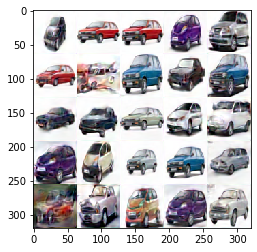

In [32]:
img = get_sample_image(G, n_noise, n_samples=25)
imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


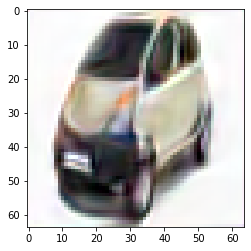

In [33]:
# Fake Image
idx = [3, 1]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
imshow(img[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

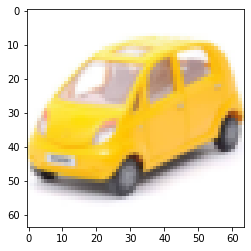

In [34]:
# Real Image
i = 14

# iterator = iter(data_loader)
# images,labels = iterator.next()

rimg = tensor2img(images[i])
imshow(rimg)

### Interpolation

In [35]:
def sample_noise(size=None):
    z = np.random.random(size=size)*2-1
    return z

In [36]:
z_a, z_b = sample_noise(n_noise), sample_noise(n_noise)
zs = torch.tensor([np.linspace(z_a[i], z_b[i], num=10) for i in range(n_noise)], dtype=torch.float32).to(DEVICE)
zs = torch.transpose(zs, 0, 1)
zs.shape

torch.Size([10, 256])

In [37]:
imgs = G(zs).detach()
imgs = torch.cat([imgs[i] for i in range(10)], dim=-1)
imgs.shape

torch.Size([3, 64, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


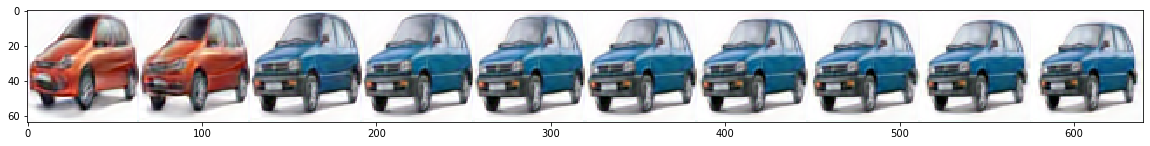

In [38]:
fig = plt.figure(figsize=(20, 3))
imshow(tensor2img(imgs))

In [44]:
g_loss.pop(0)
d_loss.pop(0)

g_loss.pop(1)
d_loss.pop(1)

g_loss.pop(2)
d_loss.pop(2)

g_loss.pop(3)
d_loss.pop(3)

g_loss.pop(4)
d_loss.pop(4)

g_loss.pop(5)
d_loss.pop(5)

for number in range(0,50):
    g_loss.pop(number)
    d_loss.pop(number)

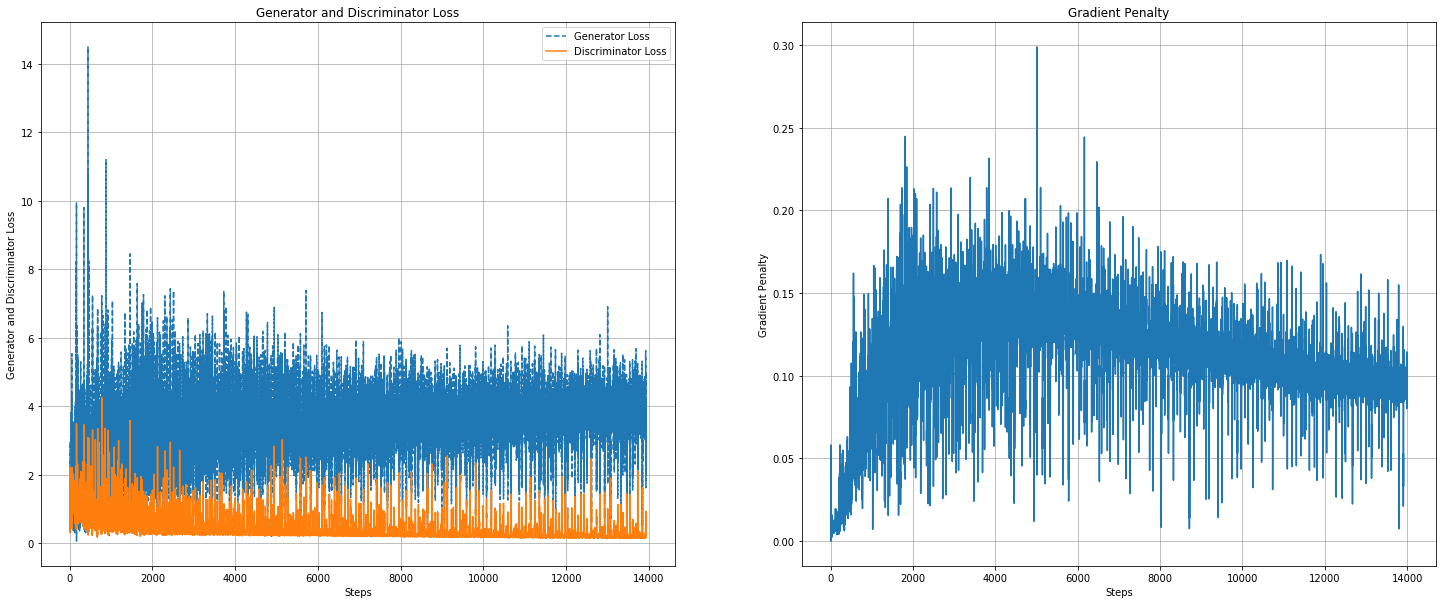

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
l, = axs[0].plot(g_loss, linestyle='--', label="Generator Loss")
l1, = axs[0].plot(d_loss, label="Discriminator Loss")
axs[0].set_title("Generator and Discriminator Loss")
axs[0].legend(loc="best", ncol=1, handles=[l, l1])
axs[0].set_xlabel('Steps')
axs[0].set_ylabel("Generator and Discriminator Loss")
axs[0].grid()
# t, = axs[1].plot(train_acc, linestyle='--', label="Train Accuracy")
# t1, = axs[1].plot(test_acc, label="Test Accuracy")
# axs[1].set_xlabel('Epochs')
# axs[1].set_ylabel('Loss')
#axs[1].set_title(
#    "Training and Test Accuracy. Max train acc = {}, max test acc = {}.".format(maxtrainacc, maxtestacc))
# axs[1].legend(loc="best", ncol=1, handles=[t, t1])
# axs[1].grid()
axs[1].plot(g_p)
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Gradient Penalty')
axs[1].set_title("Gradient Penalty")
axs[1].grid()
plt.savefig("losses.png", bbox_inches='tight')
plt.plot()
plt.show()